### Kaggle Housing Price Competition

- [Run in Google Colab](https://colab.research.google.com/github/druce/iowa/blob/master/iowa)
- [Competition leaderboard](https://www.kaggle.com/c/home-data-for-ml-course/leaderboard)
- [Data set discussion](http://jse.amstat.org/v19n3/decock.pdf)
- [Data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [1]:
from itertools import product
import operator        
import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pdf

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, lars_path, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# pointer to scaler I want to use to easily swap scalers
use_transform = RobustScaler

# not used
def mytransform():
    return QuantileTransformer(output_distribution='normal')

import scipy.stats as stats
from scipy.stats import skew  
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#!conda install -y -conda-forge  xgboost 
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

#!conda install -y -c conda-forge lightgbm
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#!conda install -y -c districtdatalabs yellowbrick
from yellowbrick.features import JointPlotVisualizer, ParallelCoordinates
from yellowbrick.regressor import AlphaSelection, PredictionError, ResidualsPlot

#!conda install -y -c conda-forge mlxtend
from mlxtend.regressor import StackingCVRegressor

import ipywidgets as widgets
from IPython.display import clear_output
pd.options.display.max_columns=None
#pd.options.display.max_rows=None

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

print(datetime.datetime.now())


2019-06-06 19:52:30.350474


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu

### 1. Import

In [2]:
# import train data
datadir = "https://raw.githubusercontent.com/druce/iowa/master/data/"
datafile = datadir + "train.csv"
df_raw = pd.read_csv(datafile)
print(df_raw.shape)
display(df_raw.head())


(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Initial exploration

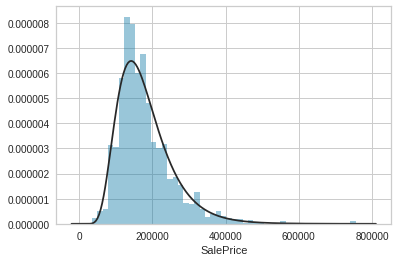

In [3]:
response = 'SalePrice'
sns.distplot(df_raw[response], kde=False, fit=stats.lognorm);


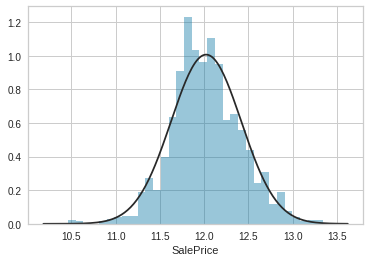

In [4]:
sns.distplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), kde=False, fit=stats.norm);


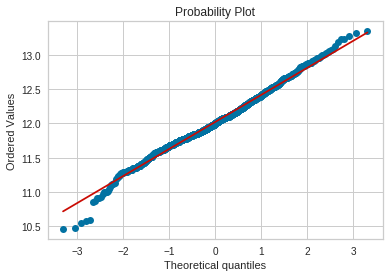

In [5]:
res = stats.probplot(np.log1p(df_raw.loc[df_raw['GrLivArea']<4000][response]), plot=plt);

In [6]:
widget_cats = []
widget_nums = []

for col in df_raw.columns:
    if col == response:
        continue
    if df_raw[col].dtype == np.dtype('O'):
        widget_cats.append(col)
    elif len(df_raw[col].value_counts()) <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)


['3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolArea', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'Id', 'LotArea', 'LotFrontage', 'MasVnrArea', 

Dropdown(description='Variable:', options=('1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'E…

Dropdown(description='Color by:', index=47, options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCo…

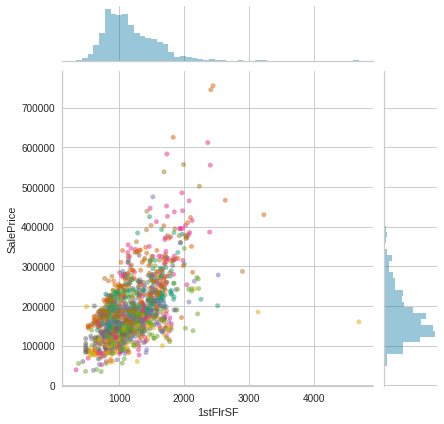

In [7]:
# interactive widget for continuous variables
df = df_raw
def on_value_change1(change):
    do_refresh(change['new'], gColor)

def on_value_change2(change):
    do_refresh(gVar, change['new'])

def do_refresh(var=widget_nums[0], colorby="Neighborhood"):

    global gVar
    gVar = var
    global gColor
    gColor = colorby
    
    clear_output()
    dropdown1 = widgets.Dropdown(
        options=widget_nums,
        value=var,
        description='Variable:',
        disabled=False,)
    display(dropdown1)

    dropdown1.observe(on_value_change1, names='value')

    dropdown2 = widgets.Dropdown(
        options=widget_cats,
        value=colorby,
        description='Color by:',
        disabled=False,)
    display(dropdown2)
    dropdown2.observe(on_value_change2, names='value')
    
    z = df.loc[~df[response].isna()]

    norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
    
    colordict = {k: i for i, k in enumerate(z[colorby].unique())}
    
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  joint_kws={"color": z[colorby].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )

do_refresh()


Dropdown(description='Cat:', options=('3SsnPorch', 'Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExpos…

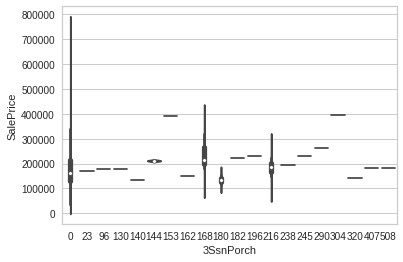

In [8]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
    

In [9]:
# import test data
datafile = datadir + "test.csv"
df_test = pd.read_csv(datafile)
df_test[response]=np.nan
df_test.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,NaN
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,NaN
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,NaN
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,NaN
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,NaN


In [10]:
# concatenate train and test for feature engineering across both
df_raw=pd.concat((df_raw, df_test)).set_index('Id')
print(df_raw.shape)


(2919, 80)


### 2. Scrub

In [11]:
df_raw.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Per docs
23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables 

Nominal (categorical)
- MS SubClass
- MS Zoning
- Street
- Alley
- Land Contour
- Lot Config
- Neighborhood
- Condition 1
- Condition 2
- Bldg Type
- House Style
- Roof Style 
- Roof Matl
- Exterior 1
- Exterior 2
- Mas Vnr Type
- Foundation
- Heating
- Central Air
- Garage Type
- Misc Feature
- Sale Type
- Sale Condition

Ordinal (categorical but map to numerical, like Po/Fa/TA/Gd/Ex)
- Lot Shape
- Utilities
- Land Slope
- Overall Qual
- Overall Cond
- Exter Qual
- Exter Cond
- Bsmt Qual
- Bsmt Cond
- Bsmt Exposure
- BsmtFin Type 1
- BsmtFinType 2
- HeatingQC
- Electrical
- KitchenQual
- Functional
- FireplaceQu
- Garage Finish 
- Garage Qual
- Garage Cond
- Paved Drive
- Pool QC
- Fence

Discrete (int)
- Year Built
- Year Remod/Add
- Bsmt Full Bath
- Bsmt Half Bath
- Full Bath
- Half Bath
- Bedroom
- Kitchen
- TotRmsAbvGrd
- Fireplaces
- Garage Yr Blt 
- Garage Cars
- Mo Sold
- Yr Sold

Continuous (float)
- Lot Frontage
- Lot Area
- Mas Vnr Area
- BsmtFin SF 1
- BsmtFin SF 2
- Bsmt Unf SF
- Total Bsmt SF
- 1st Flr SF
- 2nd Flr SF
- Low Qual Fin SF
- Gr Liv Area
- Garage Area
- Wood Deck SF
- Open Porch SF
- Enclosed Porch
- 3-Ssn Porch
- Screen Porch
- Pool Area
- Misc Val

Response
- SalePrice


In [12]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
               'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 
               'SaleType', 'SaleCondition']

ordinal = ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 
           'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
           'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 
           'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
           'PavedDrive', 'PoolQC', 'Fence',]

numerical = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 
             'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
             'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 
             
             'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',  'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
             'GrLivArea', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

response='SalePrice'

print(df_raw.shape)
print(len(categorical))
print(len(ordinal))
print(len(numerical))
df_raw = df_raw[categorical + ordinal + numerical]
print(df_raw.shape)


(2919, 80)
23
23
34
(2919, 80)


In [13]:
df_raw.head()


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,7,5,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,SBrkr,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,Y,Attchd,NaN,WD,Normal,Reg,AllPub,Gtl,6,8,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,SBrkr,TA,Typ,TA,RFn,TA,TA,Y,NaN,NaN,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,7,5,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,Y,Detchd,NaN,WD,Abnorml,IR1,AllPub,Gtl,7,5,TA,TA,TA,Gd,No,ALQ,Unf,Gd,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,Y,Attchd,NaN,WD,Normal,IR1,AllPub,Gtl,8,5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,SBrkr,Gd,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


In [14]:
# remove sf > 4000 per docs, http://jse.amstat.org/v19n3/decock.pdf
df= df_raw.loc[~((df_raw['GrLivArea'] > 4000) & (~df_raw[response].isna()))]


#### Map categorical to int

In [15]:
# map all the columns listed as ordinal to int
# per http://jse.amstat.org/v19n3/decock/DataDocumentation.txt

# map these 9 quality label cols to int

# should write an OrdinalEncoder that 
#   orders categorical levels by increasing response
#   takes an NA argument -> mode, round mean, min, max
#   1. find correctly sorted categorical levels
#   2. fillna using appropriate val
#   3. run OrdinalEncoders using sorted levels

qdict = {
    'Po' : 0,
    'Fa' : 1,
    'TA' : 2,
    'Gd' : 3,
    'Ex' : 4,
    np.nan : 2
}

qcols = ['ExterQual',
         'ExterCond',
         'BsmtQual',
         'BsmtCond',
         'HeatingQC',
         'KitchenQual',
         'GarageQual',
         'GarageCond',
         'FireplaceQu'         
        ]

# these values are very rare (<=5), roll poor->fair, excellent->good
df.loc[df['ExterCond']=='Po', 'ExterCond'] = 'Fa'
df.loc[df['BsmtCond']=='Po', 'BsmtCond'] = 'Fa'
df.loc[df['HeatingQC']=='Po', 'HeatingQC'] = 'Fa'
df.loc[df['GarageQual']=='Po', 'GarageQual'] = 'Fa'
df.loc[df['GarageQual']=='Ex', 'GarageQual'] = 'Gd'
df.loc[df['GarageCond']=='Ex', 'GarageCond'] = 'Gd'

for col in qcols:
    print(col)
    print(df[col].value_counts())
    df.loc[:, col] = df[col].apply(lambda q: qdict[q])
    df.loc[:, col] = df[col].astype(int)
    print(df[col].value_counts())
    

ExterQual
TA    1798
Gd     978
Ex     104
Fa      35
Name: ExterQual, dtype: int64
2    1798
3     978
4     104
1      35
Name: ExterQual, dtype: int64
ExterCond
TA    2534
Gd     299
Fa      70
Ex      12
Name: ExterCond, dtype: int64
2    2534
3     299
1      70
4      12
Name: ExterCond, dtype: int64
BsmtQual
TA    1283
Gd    1209
Ex     254
Fa      88
Name: BsmtQual, dtype: int64
2    1364
3    1209
4     254
1      88
Name: BsmtQual, dtype: int64
BsmtCond
TA    2602
Gd     122
Fa     109
Name: BsmtCond, dtype: int64
2    2684
3     122
1     109
Name: BsmtCond, dtype: int64
HeatingQC
Ex    1489
TA     857
Gd     474
Fa      95
Name: HeatingQC, dtype: int64
4    1489
2     857
3     474
1      95
Name: HeatingQC, dtype: int64
KitchenQual
TA    1492
Gd    1151
Ex     201
Fa      70
Name: KitchenQual, dtype: int64
2    1493
3    1151
4     201
1      70
Name: KitchenQual, dtype: int64
GarageQual
TA    2600
Fa     129
Gd      27
Name: GarageQual, dtype: int64
2    2759
1     129
3 

In [16]:
print(df['LandSlope'].value_counts())

slope_dict = {
    'Gtl': 0,
    'Mod' : 1,
    'Sev' : 2,
}

df['LandSlope'] = df['LandSlope'].apply(lambda q: slope_dict[q])

print(df['LandSlope'].value_counts())


Gtl    2774
Mod     125
Sev      16
Name: LandSlope, dtype: int64
0    2774
1     125
2      16
Name: LandSlope, dtype: int64


In [17]:
print(df['GarageFinish'].value_counts())

garagefinish_dict = {
    np.nan : 0,
    'Unf': 1,
    'RFn' : 2,
    'Fin' : 3,
}
df['GarageFinish'] = df['GarageFinish'].apply(lambda q: garagefinish_dict[q])

print(df['GarageFinish'].value_counts())


Unf    1230
RFn     811
Fin     715
Name: GarageFinish, dtype: int64
1    1230
2     811
3     715
0     159
Name: GarageFinish, dtype: int64


In [18]:
#        Gd	Good Exposure
#        Av	Average Exposure (split levels or foyers typically score average or above)	
#        Mn	Mimimum Exposure
#        No	No Exposure
#        NA	No Basement

print(df['BsmtExposure'].value_counts())

BsmtExposure_dict = {
    np.nan : 0,
    'No' : 1,
    'Mn' : 2, 
    'Av' : 3, 
    'Gd' : 4
}
df['BsmtExposure'] = df['BsmtExposure'].apply(lambda q: BsmtExposure_dict[q])

print(df['BsmtExposure'].value_counts())


No    1904
Av     417
Gd     273
Mn     239
Name: BsmtExposure, dtype: int64
1    1904
3     417
4     273
2     239
0      82
Name: BsmtExposure, dtype: int64


In [19]:
#        Typ	Typical Functionality
#        Min1	Minor Deductions 1
#        Min2	Minor Deductions 2
#        Mod	Moderate Deductions
#        Maj1	Major Deductions 1
#        Maj2	Major Deductions 2
#        Sev	Severely Damaged
#        Sal	Salvage only

print(df['Functional'].value_counts())

functional_dict = {
    np.nan:  4,
    'Sev':   0,
    'Maj1':  0,
    'Maj2':  0,
    'Mod':   1,
    'Min2':  2,
    'Min1':  3,
    'Typ' :  4,
}
df['Functional'] = df['Functional'].apply(lambda q: functional_dict[q])

print(df['Functional'].value_counts())


Typ     2713
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64
4    2715
2      70
3      65
1      35
0      30
Name: Functional, dtype: int64


In [20]:
#        NA	No Basement
#        Unf	Unfinshed
#        LwQ	Low Quality
#        BLQ	Below Average Living Quarters	
#        Rec	Average Rec Room
#        ALQ	Average Living Quarters
#       GLQ	Good Living Quarters

print(df['BsmtFinType1'].value_counts())

bsmt_fintype_dict = {
    np.nan : 0,
    'NA' : 0,
    'Unf' : 1,
    'LwQ' : 2,
    'BLQ' : 3,
    'Rec' : 4,
    'ALQ' : 5,
    'GLQ' : 6
}

df['BsmtFinType1'] = df['BsmtFinType1'].apply(lambda q: bsmt_fintype_dict[q])

print(df['BsmtFinType1'].value_counts())

print(df['BsmtFinType2'].value_counts())
df['BsmtFinType2'] = df['BsmtFinType2'].apply(lambda q: bsmt_fintype_dict[q])
print(df['BsmtFinType2'].value_counts())


Unf    851
GLQ    845
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64
1    851
6    845
5    429
4    288
3    269
2    154
0     79
Name: BsmtFinType1, dtype: int64
Unf    2489
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64
1    2489
4     105
2      87
0      80
3      68
5      52
6      34
Name: BsmtFinType2, dtype: int64


In [21]:
#        Reg	Regular	
#        IR1	Slightly irregular
#        IR2	Moderately Irregular
#        IR3	Irregular
print(df['LotShape'].value_counts())
 
lotshape_dict = {
    np.nan : 0,
    'Reg' : 0,
    'IR1' : 1,
    'IR2' : 2,
    'IR3' : 2,
}    

df['LotShape'] = df['LotShape'].apply(lambda q: lotshape_dict[q])

print(df['LotShape'].value_counts())


Reg    1859
IR1     965
IR2      76
IR3      15
Name: LotShape, dtype: int64
0    1859
1     965
2      91
Name: LotShape, dtype: int64


In [22]:
#        SBrkr	Standard Circuit Breakers & Romex
#        FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
#        FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
#        FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
#        Mix	Mixed

print(df['Electrical'].value_counts())
 
elec_dict = {
    np.nan : 0,
    'Mix' : 0,
    'FuseP' : 0,
    'FuseF' : 2,
    'FuseA' : 3,
    'SBrkr' : 4,
}    

df['Electrical'] = df['Electrical'].apply(lambda q: elec_dict[q])

print(df['Electrical'].value_counts())


SBrkr    2667
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64
4    2667
3     188
2      50
0      10
Name: Electrical, dtype: int64


In [23]:
# Paved Drive (Ordinal): Paved driveway

#        Y	Paved 
#        P	Partial Pavement
#        N	Dirt/Gravel
        
print(df['PavedDrive'].value_counts())
 
pave_dict = {
    'N' : 0,
    'P' : 1,
    'Y' : 2,
}    

df['PavedDrive'] = df['PavedDrive'].apply(lambda q: pave_dict[q])

print(df['PavedDrive'].value_counts())


Y    2637
N     216
P      62
Name: PavedDrive, dtype: int64
2    2637
0     216
1      62
Name: PavedDrive, dtype: int64


In [24]:
# Fence (Ordinal): Fence quality
#        GdPrv	Good Privacy
#        MnPrv	Minimum Privacy
#        GdWo	Good Wood
#        MnWw	Minimum Wood/Wire
#        NA	No Fence

print(df['Fence'].value_counts())

fence_dict = {
    np.nan : 0,
    'MnWw' : 1,
    'GdWo' : 2,
    'MnPrv' : 3,
    'GdPrv' : 4,
}

df['Fence'] = df['Fence'].apply(lambda q: fence_dict[q])

print(df['Fence'].value_counts())


MnPrv    328
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64
0    2345
3     328
4     118
2     112
1      12
Name: Fence, dtype: int64


In [25]:
# Map these categorical vars 

#        1Story	One story
#        SFoyer	Split Foyer
#        SLvl	Split Level
#     1.5Fin	One and one-half story: 2nd level finished
#        1.5Unf	One and one-half story: 2nd level unfinished
#        2Story	Two story
#        2.5Fin	Two and one-half story: 2nd level finished
#        2.5Unf	Two and one-half story: 2nd level unfinished

print(df['HouseStyle'].value_counts())

story_dict = {
    '1Story' : 0,
    'SFoyer' : 1,
    'SLvl'   : 2,
    '1.5Unf' : 3,
    '1.5Fin' : 4,
    '2Story' : 5,
    '2.5Unf' : 6,
    '2.5Fin' : 7    
}

df['HouseStyle'] = df['HouseStyle'].apply(lambda q: story_dict[q])

print(df['HouseStyle'].value_counts())


1Story    1471
2Story     868
1.5Fin     314
SLvl       128
SFoyer      83
2.5Unf      24
1.5Unf      19
2.5Fin       8
Name: HouseStyle, dtype: int64
0    1471
5     868
4     314
2     128
1      83
6      24
3      19
7       8
Name: HouseStyle, dtype: int64


In [26]:
df['CentralAir'] = df['CentralAir'] == 'Y' 
df['CentralAir'] = df['CentralAir'].astype(int)


In [27]:
df.head()

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,0,AllPub,0,7,5,3,2,3,2,1,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2003,2003,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,2,2008,65.0,8450,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,548.0,0,61,0,0,0,0,0,208500.0
2,20,RL,Pave,NaN,Lvl,FR2,Veenker,Feedr,Norm,1Fam,0,Gable,CompShg,MetalSd,MetalSd,None,CBlock,GasA,1,Attchd,NaN,WD,Normal,0,AllPub,0,6,8,2,2,3,2,4,5,1,4,4,2,4,2,2,2,2,2,NaN,0,1976,1976,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,5,2007,80.0,9600,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,460.0,298,0,0,0,0,0,0,181500.0
3,60,RL,Pave,NaN,Lvl,Inside,CollgCr,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,AllPub,0,7,5,3,2,3,2,2,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2001,2002,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,9,2008,68.0,11250,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,608.0,0,42,0,0,0,0,0,223500.0
4,70,RL,Pave,NaN,Lvl,Corner,Crawfor,Norm,Norm,1Fam,5,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,GasA,1,Detchd,NaN,WD,Abnorml,1,AllPub,0,7,5,2,2,2,3,1,5,1,3,4,3,4,3,1,2,2,2,NaN,0,1915,1970,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,2,2006,60.0,9550,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,642.0,0,35,272,0,0,0,0,140000.0
5,60,RL,Pave,NaN,Lvl,FR2,NoRidge,Norm,Norm,1Fam,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,GasA,1,Attchd,NaN,WD,Normal,1,AllPub,0,8,5,3,2,3,2,3,6,1,4,4,3,4,2,2,2,2,2,NaN,0,2000,2000,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,12,2008,84.0,14260,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,836.0,192,84,0,0,0,0,0,250000.0


#### Impute / fill NAs

In [28]:
# For garage, basement, bathroom/half, assume if missing then this feature is not present

for col in ['GarageArea', 'GarageCars', 'BsmtFullBath', 'BsmtHalfBath']:
    print(col)
    df[col].fillna(0, inplace=True)
for col in ['GarageYrBlt']:
    print(col)
    df[col].fillna(df['YearBuilt'], inplace=True)
    df[col]=df[col].astype(int)
for col in ['GarageType']:
    print(col)
    df[col].fillna('None', inplace=True)

df.loc[:, 'BsmtFullBath']=df['BsmtFullBath'].astype(int)
df.loc[:, 'BsmtHalfBath']=df['BsmtHalfBath'].astype(int)
df.loc[:, 'GarageCars']=df['GarageCars'].astype(int)


GarageArea
GarageCars
BsmtFullBath
BsmtHalfBath
GarageYrBlt
GarageType


In [29]:
for col in df.columns:
    print(col)
    print (df[col].value_counts())
    print()
    

MSSubClass
20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

MSZoning
RL         2261
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

Street
Pave    2903
Grvl      12
Name: Street, dtype: int64

Alley
Grvl    120
Pave     78
Name: Alley, dtype: int64

LandContour
Lvl    2620
HLS     120
Bnk     115
Low      60
Name: LandContour, dtype: int64

LotConfig
Inside     2132
Corner      508
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    192
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     69
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
B

In [30]:
df.loc[df['MSSubClass'] == 150]

,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,YearBuilt,YearRemodAdd,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,MoSold,YrSold,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2819,150,RL,Pave,NaN,HLS,Inside,ClearCr,Norm,Norm,Twnhs,4,Gable,CompShg,VinylSd,VinylSd,None,PConc,GasA,1,Basment,NaN,WD,Normal,0,AllPub,0,7,5,3,2,3,2,2,6,1,2,4,3,4,2,3,3,2,2,NaN,0,1980,1981,1,0,2,1,2,1,7,0,1980,1,4,2006,NaN,1700,0.0,397.0,0.0,33.0,430.0,880,680,140,1700,450.0,188,36,0,0,200,0,0,NaN


In [31]:
display(df.groupby(['MSSubClass']).mean()[[response]].reset_index().sort_values(response))
display(df.groupby(['MSSubClass']).count()[[response]].reset_index().sort_values(response))

,MSSubClass,SalePrice
1,30,95829.724638
14,180,102300.000000
3,45,108591.666667
15,190,129613.333333
10,90,133541.076923
13,160,138647.380952
4,50,143302.972222
9,85,147810.000000
2,40,156125.000000
6,70,166772.416667


,MSSubClass,SalePrice
12,150,0
2,40,4
14,180,10
3,45,12
7,75,16
9,85,20
15,190,30
10,90,52
8,80,58
6,70,60


In [32]:
#        020	1-STORY 1946 & NEWER ALL STYLES
#        030	1-STORY 1945 & OLDER
#        040	1-STORY W/FINISHED ATTIC ALL AGES
#        045	1-1/2 STORY - UNFINISHED ALL AGES
#        050	1-1/2 STORY FINISHED ALL AGES
#        060	2-STORY 1946 & NEWER
#        070	2-STORY 1945 & OLDER
#        075	2-1/2 STORY ALL AGES
#        080	SPLIT OR MULTI-LEVEL
#        085	SPLIT FOYER
#        090	DUPLEX - ALL STYLES AND AGES
#        120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
#        150	1-1/2 STORY PUD - ALL AGES
#        160	2-STORY PUD - 1946 & NEWER
#        180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
#        190	2 FAMILY CONVERSION - ALL STYLES AND AGES

print(df['MSSubClass'].value_counts())

MSSubClass_dict = {
    40 : 70,
    45 : 45,
    150 : 160,
    180 : 30,
    20 : 20,
    60 : 60,
    50 : 50,
    120 : 120,
    30 : 30,
    160 : 160,
    70 : 70,
    80 : 80,
    90 : 90,
    190 : 190,
    85 : 85,
    75 : 75,
}

df['MSSubClass'] = df['MSSubClass'].apply(lambda q: MSSubClass_dict[q])

print(df['MSSubClass'].value_counts())


20     1079
60      571
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64
20     1079
60      571
50      287
120     182
30      156
70      134
160     129
80      118
90      109
190      61
85       48
75       23
45       18
Name: MSSubClass, dtype: int64


In [33]:
# fill missing MSZoning using most popular value by subclass
df.loc[:, 'MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

# fill missing LotFrontage using median value by Neighborhood
# could also impute using LotArea
df.loc[:, 'LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))


In [34]:
# impute categorical strings

oimpute = {'MSZoning' : 'RL',
           'MasVnrType' : 'None',
           'Utilities': 'AllPub',
           'Exterior1st': 'VinylSd',
           'Exterior2nd': 'VinylSd',
           'BsmtExposure' : 'No',
           'BsmtFinType1': 'Unf',
           'BsmtFinType2': 'Unf',
           'Electrical' : 'SBrkr',
           'GarageType'  : 'Attchd',
           'GarageFinish' : 'Unf',
           'GarageCond' : 'TA',
           'Functional' : 'Typ',
           'SaleType': 'WD',
           'Alley': 'None',
           'FireplaceQu': 'TA',
           'PoolQC' : 'None',
           'Fence': 'Other',
           'MiscFeature': 'Other',
          }

def impute_strings(features, ocols, groupby):
    
    for col in ocols:
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col, 'missing', features[col].isna().sum())
            print(features[col].value_counts())
            if groupby:
                features[col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mode()[0]))
            features[col].fillna(oimpute[col], inplace=True)
    return features

ocols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t == np.dtype('O')])

df = impute_strings(df, ocols, None)


Alley missing 2717
Grvl    120
Pave     78
Name: Alley, dtype: int64
Exterior1st missing 1
VinylSd    1025
MetalSd     450
HdBoard     441
Wd Sdng     410
Plywood     221
CemntBd     125
BrkFace      87
WdShing      56
AsbShng      44
Stucco       42
BrkComm       6
Stone         2
CBlock        2
AsphShn       2
ImStucc       1
Name: Exterior1st, dtype: int64
Exterior2nd missing 1
VinylSd    1014
MetalSd     447
HdBoard     405
Wd Sdng     391
Plywood     270
CmentBd     125
Wd Shng      81
BrkFace      47
Stucco       46
AsbShng      38
Brk Cmn      22
ImStucc      14
Stone         6
AsphShn       4
CBlock        3
Other         1
Name: Exterior2nd, dtype: int64
MasVnrType missing 24
None       1741
BrkFace     878
Stone       247
BrkCmn       25
Name: MasVnrType, dtype: int64
MiscFeature missing 2810
Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64
SaleType missing 1
WD       2523
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw 

In [35]:
# impute mean for missing floats - mean by neighborhood

def impute_floats(features, fcols, groupby='Neighborhood', response=response):

    for col in fcols:
        if col == response:
            continue
        nmissing = features[col].isna().sum()
        if nmissing:
            print(col)
            print('missing', features[col].isna().sum())
            display(df.loc[df[col].isna()])
            if groupby:
                features.loc[:,col] = features.groupby(groupby)[col].transform(lambda x: x.fillna(x.mean()))
            else:
                features.loc[:,col] = features[col].mean()
                
    return features

# set this to 0 since MasVnrType is always 'None' when MasVnrArea is nan
df.loc[df['MasVnrArea'].isna(), 'MasVnrArea'] = 0

# set this to 0 since these do not seem to have a basement
df.loc[df['BsmtFinSF1'].isna(), 'BsmtFinSF1'] = 0
df.loc[df['BsmtFinSF2'].isna(), 'BsmtFinSF2'] = 0
df.loc[df['BsmtUnfSF'].isna(), 'BsmtUnfSF'] = 0
df.loc[df['TotalBsmtSF'].isna(), 'TotalBsmtSF'] = 0

fcols = list([df.columns[i] for i,t in enumerate(list(df.dtypes)) if t in numeric_dtypes])

df = impute_floats(df, fcols, 'Neighborhood')


In [36]:
# map all remaining categorical variables to ints by grouping and sorting by mean SalePrice
# i.e. categorical var with lowest average saleprice maps to 0, next lowest is 1, etc.
# numeric values potentially allow interaction features

labelencoded = []

def myLabelEncoder(df, column, target, order_only=True, verbose=True):
    
    temp_df= df.loc[~df[target].isna()][[column, target]] \
        .groupby(column) \
        .agg(np.mean) \
        .sort_values(target) \
        .reset_index()
    
    if order_only == True:
        mapdict = dict(zip(temp_df[column], temp_df.index))
    else:
        mapdict = dict(zip(temp_df[column], temp_df[target]))

    mapdict[np.nan] = np.nan

    if verbose:
        print(mapdict)
    
    return df[column].apply(lambda q: mapdict[q])

for col in df.columns:
    if df[col].dtype in numeric_dtypes:
        continue
    else:
        df[col] = myLabelEncoder(df, col, response)
        labelencoded.append(col)

{'C (all)': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4, nan: nan}
{'Grvl': 0, 'Pave': 1, nan: nan}
{'Grvl': 0, 'Pave': 1, 'None': 2, nan: nan}
{'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3, nan: nan}
{'Inside': 0, 'Corner': 1, 'FR2': 2, 'FR3': 3, 'CulDSac': 4, nan: nan}
{'MeadowV': 0, 'IDOTRR': 1, 'BrDale': 2, 'BrkSide': 3, 'Edwards': 4, 'OldTown': 5, 'Sawyer': 6, 'Blueste': 7, 'SWISU': 8, 'NPkVill': 9, 'NAmes': 10, 'Mitchel': 11, 'SawyerW': 12, 'NWAmes': 13, 'Gilbert': 14, 'Blmngtn': 15, 'CollgCr': 16, 'Crawfor': 17, 'ClearCr': 18, 'Somerst': 19, 'Veenker': 20, 'Timber': 21, 'StoneBr': 22, 'NoRidge': 23, 'NridgHt': 24, nan: nan}
{'Artery': 0, 'RRAe': 1, 'Feedr': 2, 'Norm': 3, 'RRAn': 4, 'RRNe': 5, 'RRNn': 6, 'PosN': 7, 'PosA': 8, nan: nan}
{'RRNn': 0, 'Artery': 1, 'Feedr': 2, 'RRAn': 3, 'Norm': 4, 'RRAe': 5, 'PosA': 6, 'PosN': 7, nan: nan}
{'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, 'TwnhsE': 3, '1Fam': 4, nan: nan}
{'Gambrel': 0, 'Gable': 1, 'Mansard': 2, 'Flat': 3, 'Hip': 4, 'Shed': 5, nan: nan}
{'

#### Roll up rare categorical values

In [37]:
print(df['OverallQual'].value_counts())
df.loc[df['OverallQual'] == 1, 'OverallQual'] = 2
print(df['OverallQual'].value_counts())

print(df['OverallCond'].value_counts())
df.loc[df['OverallCond'] == 1, 'OverallCond'] = 2
print(df['OverallCond'].value_counts())


5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      13
1       4
Name: OverallQual, dtype: int64
5     825
6     731
7     600
8     342
4     226
9     107
3      40
10     27
2      17
Name: OverallQual, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64
5    1642
6     530
7     390
8     144
4     101
3      50
9      41
2      17
Name: OverallCond, dtype: int64


In [38]:
# roll up low cardinality categorical variables

def rollup_low_cardinality(features, threshold):
    """Rollup least frequent categorical features, up to total threshold observations rolled up"""
    for col in features.columns:
        # skip numerics
        if (features[col].dtype in numeric_dtypes):
            continue
        
        print(col)
        counts = features[col].value_counts()
        howmany=0
        vals = []
        for i, (val, c) in reversed(list(enumerate(zip(list(counts.index), list(counts))))):
            if howmany + c < threshold:
                print(val, c)
                howmany += c
                vals += [val]
            else:
                break
        if len(vals) > 1:
            print ('Rollup', vals)
            for v in vals:
                features.loc[features[col] == v, col] = 'Rollup'
        print()
    return features

def rollup_low_cardinality_int(df, preds, threshold):
    """Rollup least frequent ordered features
    if < threshold, roll into next higher
    if highest, roll into next lower
    """
    for col in preds:
        print(col)
        counts = df[col].value_counts()
        counts = df[col].value_counts().sort_index()
        print(counts)
        indexlist = list(counts.index)
        for i, val in enumerate(indexlist):
            if counts[val] < threshold:
                if val < len(indexlist)-1:
                    # not last
                    print(val, '=>', indexlist[i+1])
                    df.loc[df[col]==val, col] = indexlist[i+1]
                    # update counts so you don't roll up if now > thresh
                    counts[indexlist[i+1]] += counts[indexlist[i]]
                else:
                    print(val, '=>', indexlist[i-1])
                    df.loc[df[col]==val, col] = indexlist[i-1]
                    #no need to update since last

    return df

df = rollup_low_cardinality(df, 25)

intcats = ['LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType',
           'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
           'Heating','GarageType','SaleType','SaleCondition','LotShape','LandSlope',
           'ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','Electrical',
           'KitchenQual','GarageFinish','GarageQual','GarageCond','PavedDrive',
           'BsmtFullBath','HalfBath','KitchenAbvGr','Fireplaces',]

df = rollup_low_cardinality_int(df, intcats, 5)


LandContour
0     115
1    2620
2      60
3     120
Name: LandContour, dtype: int64
LotConfig
0    2132
1     508
2      85
3      14
4     176
Name: LotConfig, dtype: int64
Neighborhood
0      37
1      93
2      30
3     108
4     192
5     239
6     151
7      10
8      48
9      23
10    443
11    114
12    125
13    131
14    165
15     28
16    267
17    103
18     44
19    182
20     24
21     72
22     51
23     69
24    166
Name: Neighborhood, dtype: int64
Condition1
0      92
1      28
2     163
3    2509
4      50
5       6
6       9
7      38
8      20
Name: Condition1, dtype: int64
Condition2
0       2
1       5
2      13
3       1
4    2886
5       1
6       4
7       3
Name: Condition2, dtype: int64
0 => 1
3 => 4
5 => 6
7 => 6
BldgType
0      62
1     109
2      96
3     227
4    2421
Name: BldgType, dtype: int64
RoofStyle
0      22
1    2309
2      11
3      20
4     548
5       5
Name: RoofStyle, dtype: int64
RoofMatl
0       1
1    2874
2       1
3      23
4       9
5

#### Engineer

In [39]:
# Compute additional features

#df['MS SubClass']=df['MS SubClass'].astype(str)
df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['BsmtFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
df['PorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

df['BsmtFullBath'].fillna(0, inplace=True)
df.loc[df['BsmtFullBath'] > 2, 'BsmtFullBath'] = 2
df['BsmtHalfBath'].fillna(0, inplace=True)
df['TotalBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath'] + df['FullBath'] + 0.5 * df['HalfBath']
df.loc[df['TotalBath'] >=4, 'TotalBath'] = 4
df['BsmtBath'] = df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
df.loc[df['BsmtBath'] >= 1, 'BsmtBath'] = 1

df['BsmtFullBath'] = df['BsmtFullBath'].astype(int)
df.drop(columns=['BsmtHalfBath'], inplace=True)

df['AvgBltRemod'] = (df['YearBuilt'] + df['YearRemodAdd']) / 2
df['AvgBltRemod'] = 2010 - df['AvgBltRemod'] 
df['YearBuilt'] = 2010 - df['YearBuilt'] 
df['YearRemodAdd'] = 2010 - df['YearRemodAdd'] 
df['GarageYrBlt'] = 2010 - df['GarageYrBlt'] 

# cap and floor outliers
df.loc[df['KitchenAbvGr'] > 2, 'KitchenAbvGr'] = 2
df.loc[df['GarageCars'] >= 3, 'GarageCars'] = 3
df.loc[df['TotRmsAbvGrd'] <=3, 'TotRmsAbvGrd'] = 3
df.loc[df['BedroomAbvGr'] > 6, 'BedroomAbvGr'] = 6
df.loc[df['TotRmsAbvGrd'] > 12, 'TotRmsAbvGrd'] = 12
df.loc[df['Fireplaces'] >= 3, 'Fireplaces'] = 3

# fix 1 bad value
df.loc[df['GarageYrBlt'] < 0, 'GarageYrBlt'] = 0

# Booleans
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
#df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
#df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

# Ratios
df['LivAreaRatio'] = df['TotalSF'] / df['LotArea']
df['BedRatio'] = df['GrLivArea'] / df['BedroomAbvGr']
df.loc[df['BedRatio'] > 2500, 'BedRatio'] = 2500
df['GarageRatio']  = df['GarageCars'] / df['BedroomAbvGr']
df.loc[df['GarageRatio'] > 5, 'GarageRatio'] = 5
df['BathRatio'] = df['TotalBath'] /  df['BedroomAbvGr']
df.loc[df['BathRatio'] > 5, 'BathRatio'] = 5
df['LotRatio'] = df['LotArea'] / df['LotFrontage']
df.loc[df['LotRatio'] > 500, 'LotRatio'] = 500
df['FireBathRatio'] = df['Fireplaces'] / df['TotalBath']
df.loc[df['FireBathRatio'] > 1.5, 'FireBathRatio'] = 1.5
# merge unpaved, partial paved
df.loc[df['PavedDrive']==1,'PavedDrive'] = 0

# df['OverallQualRatio'] = (df['OverallQual'] + 1) / (df['OverallCond'] + 1)
# df['ExterQualRatio'] = (df['ExterQual'] + 1) / (df['ExterCond'] + 1)
# df['BsmtQualRatio'] = (df['BsmtQual'] + 1) / (df['BsmtCond']   + 1)
# df['GarageQualRatio'] = (df['GarageQual'] + 1) / (df['GarageCond']   + 1)

# df['Gr Liv Area x Overall Qual'] = df['Gr Liv Area'] * df['Overall Qual']

# interaction features, have residual correlation and also look reasonable
df['TotalSF x OverallQual x OverallCond'] = df['TotalSF'] * df['OverallQual'] * df['OverallCond']
df['TotalSF x OverallQual x Functional'] = df['TotalSF'] * df['OverallQual'] * df['Functional']
df['AvgBltRemod x Functional x TotalFinSF'] = df['AvgBltRemod'] * df['Functional'] * df['TotalFinSF']

df['TotalSF x OverallQual'] = df['TotalSF'] * df['OverallQual']
df['TotalSF x OverallCond'] = df['TotalSF'] * df['OverallCond']
df['TotalFinSF x Functional'] = df['Functional'] * df['TotalFinSF']
#df['OverallQual x OverallCond'] = df['OverallQual'] * df['OverallCond']
df['Functional x OverallQual'] = df['Functional'] * df['OverallQual']
df['AvgBltRemod x OverallCond'] = df['AvgBltRemod'] * df['OverallCond']
df['AvgBltRemod x TotalFinSF'] = df['AvgBltRemod'] * df['TotalFinSF']
#df['YearBuilt x OverallCond'] = df['YearBuilt'] * df['OverallCond']
df['OverallCond x AvgBltRemod'] = df['OverallCond'] * df['AvgBltRemod']

df['BsmtFinSF x BsmtQual'] = df['BsmtFinSF'] * df['BsmtQual']
df['BsmtFinSF x BsmtBath'] = df['BsmtFinSF'] * df['BsmtBath']
df['KitchenAbvGr x KitchenQual'] = df['KitchenAbvGr'] * df['KitchenQual']
df['GarageCars x GarageYrBlt'] = df['GarageCars'] * df['GarageYrBlt']

#df['ExterQual x ExterCond x Exterior1st'] = df['ExterQual'] * df['ExterCond'] * df['Exterior1st']
#df['BsmtQual x BsmtCond x BsmtFinSF'] = df['BsmtQual'] * df['BsmtCond'] * df['BsmtFinSF']
df['GarageQual x GarageCond x GarageCars'] = df['GarageQual'] * df['GarageCond'] * df['GarageCars']

df['HeatingQC x Heating'] = df['HeatingQC'] * df['Heating']
df['FireplaceQu x Fireplaces'] = df['FireplaceQu'] * df['Fireplaces']
         

In [40]:
# add sequential month index to capture any trend
def add_trend(features, datecols=['YrSold', 'MoSold']):
    yearmo = features[datecols]

    yearmo = yearmo.sort_values(datecols) \
        .groupby(datecols) \
        .first()\
        .reset_index() \
        .reset_index() \
        .rename(columns={'index': 'monthnum'})

    display(yearmo.head(5))
    display(yearmo.tail(5))

    print(features.shape)
    # merge messes up the order, so reset index, merge, apply index, sort index
    features.reset_index(inplace=True)
    
    features = features.merge(yearmo, on=datecols)
    features.set_index('Id', inplace=True)
    features.sort_index(inplace=True)
    print(features.shape)
    return features

df = add_trend(df)
df.drop(columns=['YrSold'], inplace=True)


,monthnum,YrSold,MoSold
0,0,2006,1
1,1,2006,2
2,2,2006,3
3,3,2006,4
4,4,2006,5


,monthnum,YrSold,MoSold
50,50,2010,3
51,51,2010,4
52,52,2010,5
53,53,2010,6
54,54,2010,7


(2915, 112)
(2915, 113)


#### Transform (logs, squares)

In [41]:
# we test variables below to see if log or square has higher correlation with response and transform accordingly

transformsquare = ['BsmtUnfSF', '2ndFlrSF', 'BsmtFinSF', 'BsmtFinSF x BsmtQual']

for col in transformsquare:
    print(col)
    df[col] = df[col] ** 2
    df.rename(columns={col : 'sq' + col}, inplace=True)


BsmtUnfSF
2ndFlrSF
BsmtFinSF
BsmtFinSF x BsmtQual


In [42]:
list(df.columns)

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LandContour',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'GarageType',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'LotShape',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'MoSold',
 'LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'sqBsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 'sq2ndFlrSF',
 'LowQualFinSF',

In [43]:
transformlog = ['LotArea', 'YearBuilt', 'GrLivArea', 'GarageYrBlt', 'TotalFinSF', 
                #'ExterCond' 'BsmtFinType2', 'BsmtExposure',
                'LivAreaRatio', 'BedRatio', 'BathRatio', 'LotRatio', 
                #'OverallQualRatio','ExterQualRatio','BsmtQualRatio','GarageQualRatio',
                'TotalSF x OverallQual', 
                'TotalSF x OverallCond',#'OverallQual x OverallCond',
                'AvgBltRemod x OverallCond',
                'AvgBltRemod x TotalFinSF',#'YearBuilt x OverallCond',
                'OverallCond x AvgBltRemod',
               ]

for col in transformlog:
    print(col)
    df[col] = np.log1p(df[col])
    df.rename(columns={col : 'log' + col}, inplace=True)


LotArea
YearBuilt
GrLivArea
GarageYrBlt
TotalFinSF
LivAreaRatio
BedRatio
BathRatio
LotRatio
TotalSF x OverallQual
TotalSF x OverallCond
AvgBltRemod x OverallCond
AvgBltRemod x TotalFinSF
OverallCond x AvgBltRemod


#### Fix highly skewed predictors

In [44]:
### unskew, shrink outliers

def unskew_features(features, high_skew=0.5):
    
    numeric_col_ix = [i for i in features.columns if features[i].dtype in numeric_dtypes]

    skew_features = features[numeric_col_ix].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skew_features[skew_features > high_skew]
    skew_index = high_skew.index

    for i in skew_index:
        print(i)
        try:
            features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))
        except:
            pass

    return features

# doesn't seem to help, we already transformed with logs and squares
# df = unskew_features(df)

### 3. Review and Setup

In [45]:
# transform target to log target, expm1 at end
df[response] = np.log1p(df[response])

In [46]:
# drop these based on ProfileReport

dropcols = ['3SsnPorch',
            'EnclosedPorch',
            'OpenPorchSF',
            'ScreenPorch',
            'WoodDeckSF',
            'BsmtFinSF1',
            'BsmtFinSF2',
            'LowQualFinSF',
            'MiscVal',
            'MiscFeature',
            'PoolArea',
            'Street', 
            'FireplaceQu',
            'LandContour'
           ]

df.drop(columns=dropcols, inplace=True)
print(df.shape)


(2915, 98)


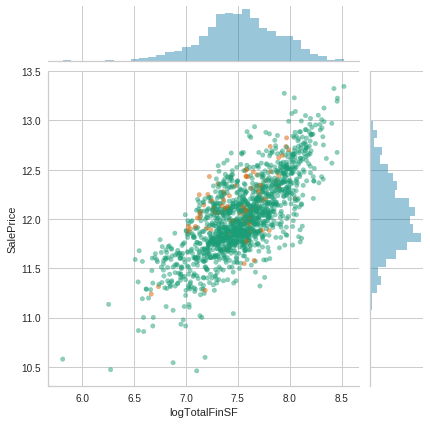

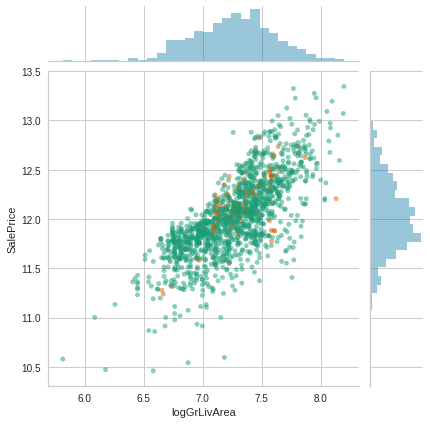

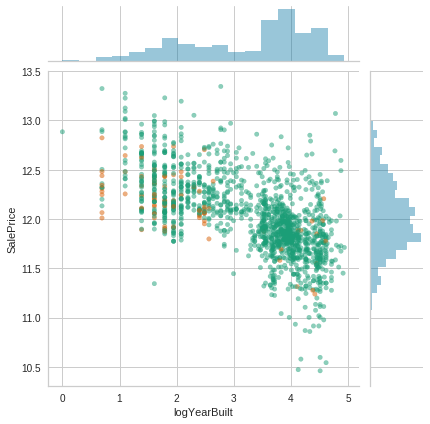

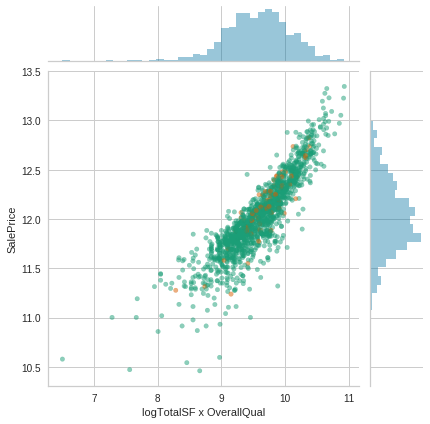

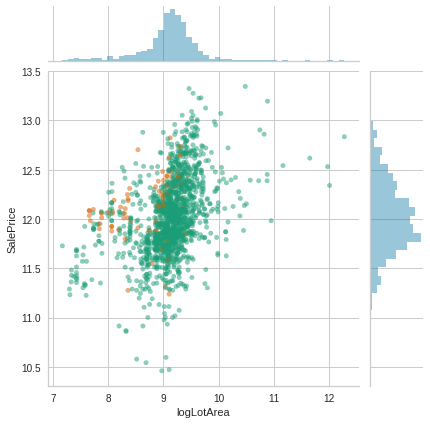

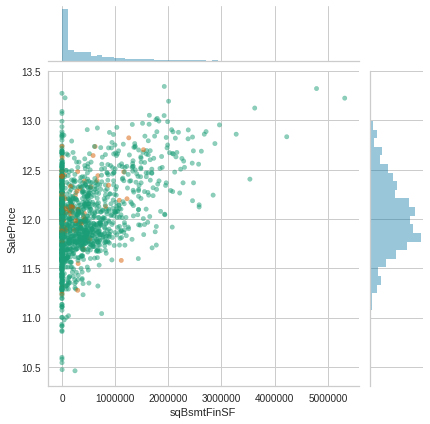

In [47]:
# few charts

z = df.loc[~df[response].isna()]

norm = matplotlib.colors.Normalize(vmin=0, vmax=21, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Dark2)
colordict = {k: i for i, k in enumerate(z['MSZoning'].unique())}

for var in ['logTotalFinSF','logGrLivArea','logYearBuilt','logTotalSF x OverallQual','logLotArea','sqBsmtFinSF',]:
    sns.jointplot(var, 
                  response, 
                  data=z, 
                  alpha=0.5, 
                  s=20, 
                  joint_kws={"color": z['MSZoning'].apply(lambda x: matplotlib.colors.to_hex(mapper.to_rgba(colordict[x])))}
                 )
    

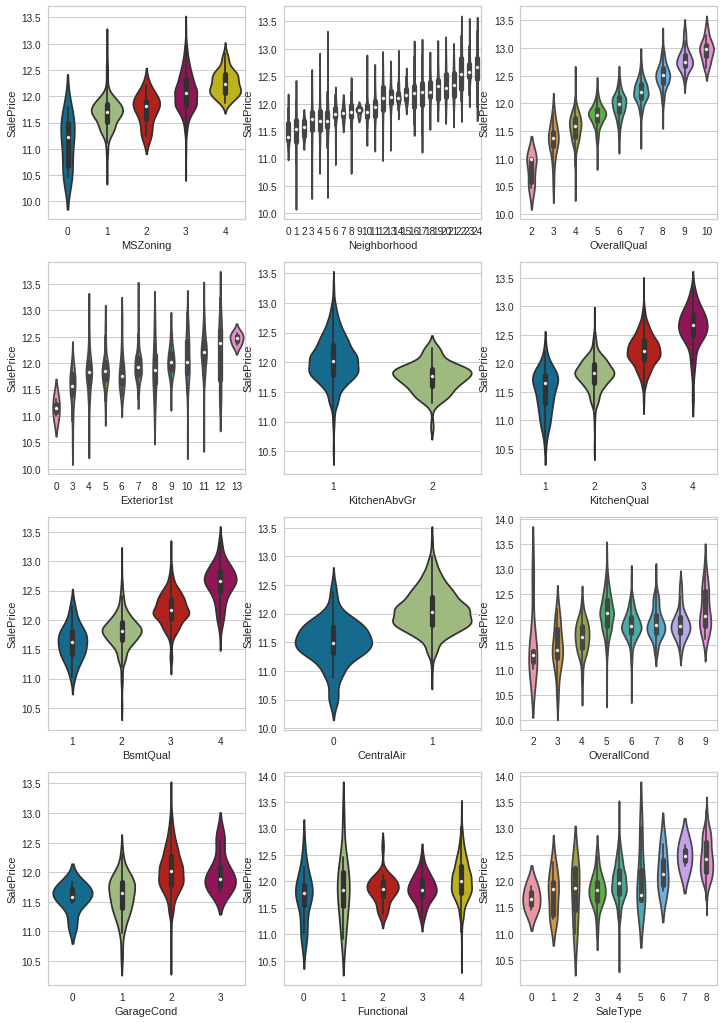

In [48]:
fig, ax = plt.subplots(figsize=(12,18), ncols=3, nrows=4)

for i, var in enumerate(['MSZoning','Neighborhood','OverallQual','Exterior1st','KitchenAbvGr','KitchenQual',
                         'BsmtQual', 'CentralAir','OverallCond','GarageCond','Functional','SaleType',]):
    sns.violinplot(x=var, y=response, data=z, ax = ax[i // 3][i % 3])    


In [49]:
widget_cats = []
widget_nums = []

for col in df.columns:
    if col == response:
        continue
    cardinality = len(df[col].value_counts())
    if cardinality <= 25:
        widget_cats.append(col)
    else:
        widget_nums.append(col)
        
widget_cats.sort()        
print(widget_cats)
print()
widget_nums.sort()
print(widget_nums)

['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireBathRatio', 'FireplaceQu x Fireplaces', 'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'Functional x OverallQual', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageQual x GarageCond x GarageCars', 'GarageRatio', 'GarageType', 'HalfBath', 'Heating', 'HeatingQC', 'HeatingQC x Heating', 'HouseStyle', 'KitchenAbvGr', 'KitchenAbvGr x KitchenQual', 'KitchenQual', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MoSold', 'Neighborhood', 'OverallCond', 'OverallQual', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'TotRmsAbvGrd', 'TotalBath', 'Utilities', 'has2ndfloor', 'hasfireplace', 'haspool']

['1stFlrSF', 'AvgBltRemod', 'AvgBltRemod x Functional x 

Dropdown(description='Variable:', options=('1stFlrSF', 'AvgBltRemod', 'AvgBltRemod x Functional x TotalFinSF',…

Dropdown(description='Color by:', index=48, options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCon…

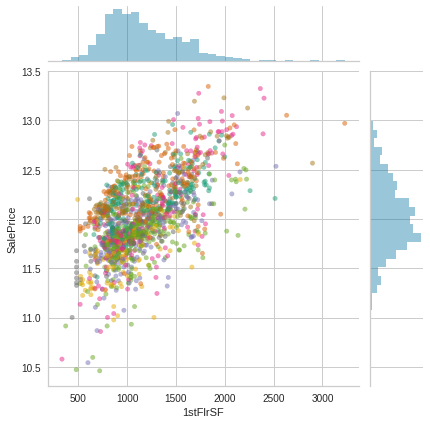

In [50]:
# interactive widget for continuous variables

do_refresh()
    


Dropdown(description='Cat:', options=('Alley', 'BedroomAbvGr', 'BldgType', 'BsmtBath', 'BsmtCond', 'BsmtExposu…

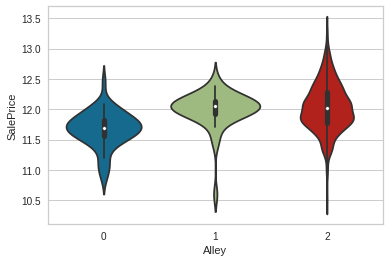

In [51]:
# interactive widget for categorical variables

def on_value_change3(change):
    do_refresh3(change['new'])

def do_refresh3(var=widget_cats[0]):

    clear_output()
    dropdown3 = widgets.Dropdown(
        options=widget_cats,
        value=var,
        description='Cat:',
        disabled=False,)
    display(dropdown3)
    dropdown3.observe(on_value_change3, names='value')
    
    z = df.loc[~df[response].isna()]

    sns.violinplot(x=var, y=response, data=z)    

do_refresh3()
        

In [52]:
### compare correlations of log, linear, square, add transforms as necessary
### make categorical if low cardinality

z = df.loc[~df[response].isna()]
for col in z.columns:
    if z[col].dtype not in numeric_dtypes:
        continue
    elif col==response:
        continue
    log = (np.corrcoef(np.log1p(z[col]), z[response])[0,1])
    linear = (np.corrcoef(z[col], z[response])[0,1])
    square = (np.corrcoef(z[col]**2, z[response])[0,1])
    print(col, 'log', log, 'linear', linear, 'square', square)
    

MSSubClass log -0.0004798907734951526 linear -0.04514451690638043 square -0.09328233312170445
MSZoning log 0.41753275148485824 linear 0.41279756852904714 square 0.3968974086646346
Alley log 0.16242653532499024 linear 0.15754606824608658 square 0.1454785444063308
LotConfig log 0.12785450847566468 linear 0.14424571916822732 square 0.1537406785470078
Neighborhood log 0.6886270727823947 linear 0.7420311981460962 square 0.7282914789507746
Condition1 log 0.1850577692219324 linear 0.18380549468895432 square 0.14073313864977835
Condition2 log 0.10212307960484668 linear 0.10726550305334924 square 0.10860889036903383
BldgType log 0.18116649123563208 linear 0.183155943702183 square 0.17511133594202238
HouseStyle log 0.11447612264187941 linear 0.1393572946258224 square 0.1696622861142495
RoofStyle log 0.20614395906459587 linear 0.20475409957822752 square 0.2027659110664456
RoofMatl log 0.09410713890389882 linear 0.0989822872504551 square 0.1022218593024256
Exterior1st log 0.4172131261188554 linear

In [53]:
# make these strings, forces dummification (could also just specify columns to dummify)
# transformstr = ['HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtFullBath', 'TotRmsAbvGrd', 'Fireplaces', 
#                 'GarageQual', 'TotalBath', 'BsmtBath',  'HalfBath', 'MSSubClass',]

categorical_str = [
    'BldgType',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'Condition1',
    'Condition2',
    'Electrical',
    'ExterCond',
    'ExterQual',
    'Exterior1st',
    'Exterior2nd',
    'Fence',
#    'FireplaceQu',
    'Fireplaces',
    'Foundation',
    'Functional',
    'GarageCars',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
#    'GarageQual x GarageCond x GarageCars',
    'Heating',
    'HeatingQC',
    'HouseStyle',
    'KitchenQual',
#    'LandContour',
    'LandSlope',
    'LotConfig',
    'LotShape',
    'MSSubClass',
    'MSZoning',
    'MasVnrType',
    'MoSold',
    'Neighborhood',
    'OverallCond',
    'OverallQual',
    'PavedDrive',
    'RoofMatl',
    'RoofStyle',
    'SaleCondition',
    'SaleType',
#    'monthnum',
    'BedroomAbvGr',
    'BsmtBath',
#    'FireBathRatio',
    'HalfBath',
#    'MiscFeature',
    'PoolQC',
    'TotalBath',
#    'FireplaceQu x Fireplaces',
#    'GarageRatio',
#    'KitchenAbvGr x KitchenQual',
#    'Functional x OverallQual',
]


for col in categorical_str:
    cardinality = df[col].value_counts().shape[0]
    #    if ((cardinality <= 4) and (cardinality > 2) or (col in labelencoded)):
    print(col, cardinality)
    df[col] = df[col].apply(str)

        

BldgType 5
BsmtCond 3
BsmtExposure 5
BsmtFinType1 7
BsmtFinType2 7
BsmtQual 4
CentralAir 2
Condition1 9
Condition2 4
Electrical 4
ExterCond 4
ExterQual 4
Exterior1st 12
Exterior2nd 13
Fence 5
Fireplaces 4
Foundation 6
Functional 5
GarageCars 4
GarageCond 4
GarageFinish 4
GarageQual 3
GarageType 7
Heating 4
HeatingQC 4
HouseStyle 8
KitchenQual 4
LandSlope 3
LotConfig 5
LotShape 3
MSSubClass 13
MSZoning 5
MasVnrType 4
MoSold 12
Neighborhood 25
OverallCond 8
OverallQual 9
PavedDrive 2
RoofMatl 4
RoofStyle 6
SaleCondition 6
SaleType 9
BedroomAbvGr 7
BsmtBath 3
HalfBath 3
PoolQC 4
TotalBath 7


In [54]:
# transform categorical variables to dummies
print(df.shape)
df = pd.get_dummies(df)
#drop_first doesn't help
#df = pd.get_dummies(df, drop_first=True)
print(df.shape)


(2915, 98)
(2915, 334)


In [55]:
# after dummifying, check for possible deletion or merger
low_variance = []

for i in df.columns:
    counts = df[i].value_counts()
    topval_count = counts.iloc[0]
    if topval_count / len(df) * 100 > 99.4:
        low_variance.append(i)

low_variance = list(low_variance)
low_variance


['Utilities',
 'haspool',
 'LotConfig_3',
 'Neighborhood_7',
 'Condition1_5',
 'Condition1_6',
 'Condition2_1',
 'Condition2_2',
 'Condition2_6',
 'HouseStyle_7',
 'RoofStyle_2',
 'RoofStyle_5',
 'RoofMatl_4',
 'RoofMatl_6',
 'Exterior1st_0',
 'Exterior1st_13',
 'Exterior2nd_12',
 'Exterior2nd_7',
 'Foundation_3',
 'Foundation_4',
 'Heating_1',
 'Heating_2',
 'GarageType_1',
 'SaleType_0',
 'SaleType_2',
 'SaleType_5',
 'SaleType_6',
 'SaleType_7',
 'SaleCondition_0',
 'LandSlope_2',
 'OverallQual_2',
 'OverallCond_2',
 'ExterCond_4',
 'Electrical_0',
 'GarageCond_0',
 'PoolQC_0',
 'PoolQC_1',
 'PoolQC_2',
 'PoolQC_3',
 'Fence_1',
 'BedroomAbvGr_0',
 'Fireplaces_3']

In [56]:
# drop only >= 2911 identical
dropcols = []
for col in df.columns:
    most_frequent = df[col].value_counts().iloc[0]
    if most_frequent  >= 2911:
        dropcols.append(col)
        print(col, most_frequent)


df.drop(columns=dropcols, inplace=True)


Utilities 2914
Exterior1st_13 2912
PoolQC_1 2913
PoolQC_2 2912
PoolQC_3 2912


In [57]:
# split off train, test
df_test = df.loc[df[response].isna()]
print(df_test.shape)
df_test.to_csv('df_test.csv', index=False)

df = df.loc[~df[response].isna()]
df.to_csv('df_train.csv', index=False)

print(df.shape)

predictors = [p for p in df.columns if p not in [response]]

X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[response], test_size=.25)



(1459, 329)
(1456, 329)


### 4. Tune 

In [58]:
# use 10 kfolds for CV
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


In [59]:
def evaluate(y_train, y_pred_train, y_test, y_pred_test):
    print('Train RMSE', np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('Train R-squared', r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('Train MAE', mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    print()
    print('Test RMSE', np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_test))))
    print('Test R-squared', r2_score(np.expm1(y_test), np.expm1(y_pred_test)))
    print('Test MAE', mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_test)))

def evaluate2(y_train, y_pred_train, prefix = "Train"):
    print('%s RMSE (log)' % prefix, np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('%s RMSE' % prefix, np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_pred_train))))
    print('%s R-squared' % prefix, r2_score(np.expm1(y_train), np.expm1(y_pred_train)))
    print('%s MAE' % prefix, mean_absolute_error(np.expm1(y_train), np.expm1(y_pred_train)))
    return r2_score(np.expm1(y_train), np.expm1(y_pred_train))


In [60]:
%%time
# linear regression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)

scores = np.sqrt(-cross_val_score(reg, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print()
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()


Train RMSE 14958.868732740344
Train R-squared 0.960389351192257
Train MAE 10195.552934244415

Test RMSE 23341.647113650717
Test R-squared 0.9170188688859416
Test MAE 14697.282150243422

CV Score 0.1428 (STD 0.0619)

CPU times: user 1.31 s, sys: 48 ms, total: 1.36 s
Wall time: 229 ms


alpha 0.0005623413251903491
Train RMSE 16844.44141804775
Train R-squared 0.9497741053506805
Train MAE 11196.524644207178

Test RMSE 19749.40417247662
Test R-squared 0.9405948156478718
Test MAE 12548.811839408412


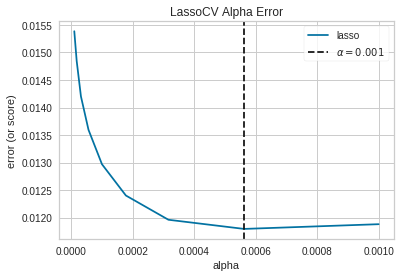

CPU times: user 19.5 s, sys: 340 ms, total: 19.9 s
Wall time: 3.6 s


In [61]:
%%time
# lasso, visualize with yellowbrick
scaler = use_transform()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)

#alphas = np.logspace(-5, 4, 19)
alphas = np.logspace(-5, -3, 9)
visualizer = AlphaSelection(LassoCV(alphas=alphas, max_iter=200000, cv=kfolds))
visualizer.fit(X_tr, y_train)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

visualizer.poof()


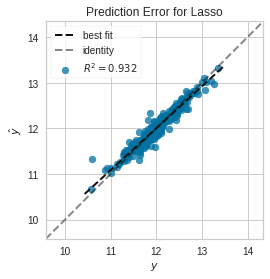

CPU times: user 1.11 s, sys: 12 ms, total: 1.12 s
Wall time: 188 ms


In [62]:
%%time
visualizer = PredictionError(Lasso(alpha=alpha))
visualizer.fit(X_tr, y_train)
visualizer.score(scaler.transform(X_test), y_test)
visualizer.poof()


In [63]:
%%time
# tune LassoCV search space
# note train error is worse when using lasso regularization but test is better
# regularization reduces overfitting

lasso = make_pipeline(use_transform(),
                      LassoCV(alphas=np.logspace(-4, -2, 11),
                              max_iter=100000,
                              cv=kfolds))

scores = np.sqrt(-cross_val_score(lasso, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

lasso.fit(X_train, y_train)

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)

print('alpha', lasso._final_estimator.alpha_)


CV Score 0.1063 (STD 0.0122)

Train RMSE 16997.671623180388
Train R-squared 0.9488561610949425
Train MAE 11276.996319232801

Test RMSE 19906.268559330987
Test R-squared 0.9396473880516104
Test MAE 12645.433019559863
alpha 0.000630957344480193
CPU times: user 33.7 s, sys: 532 ms, total: 34.3 s
Wall time: 5.72 s


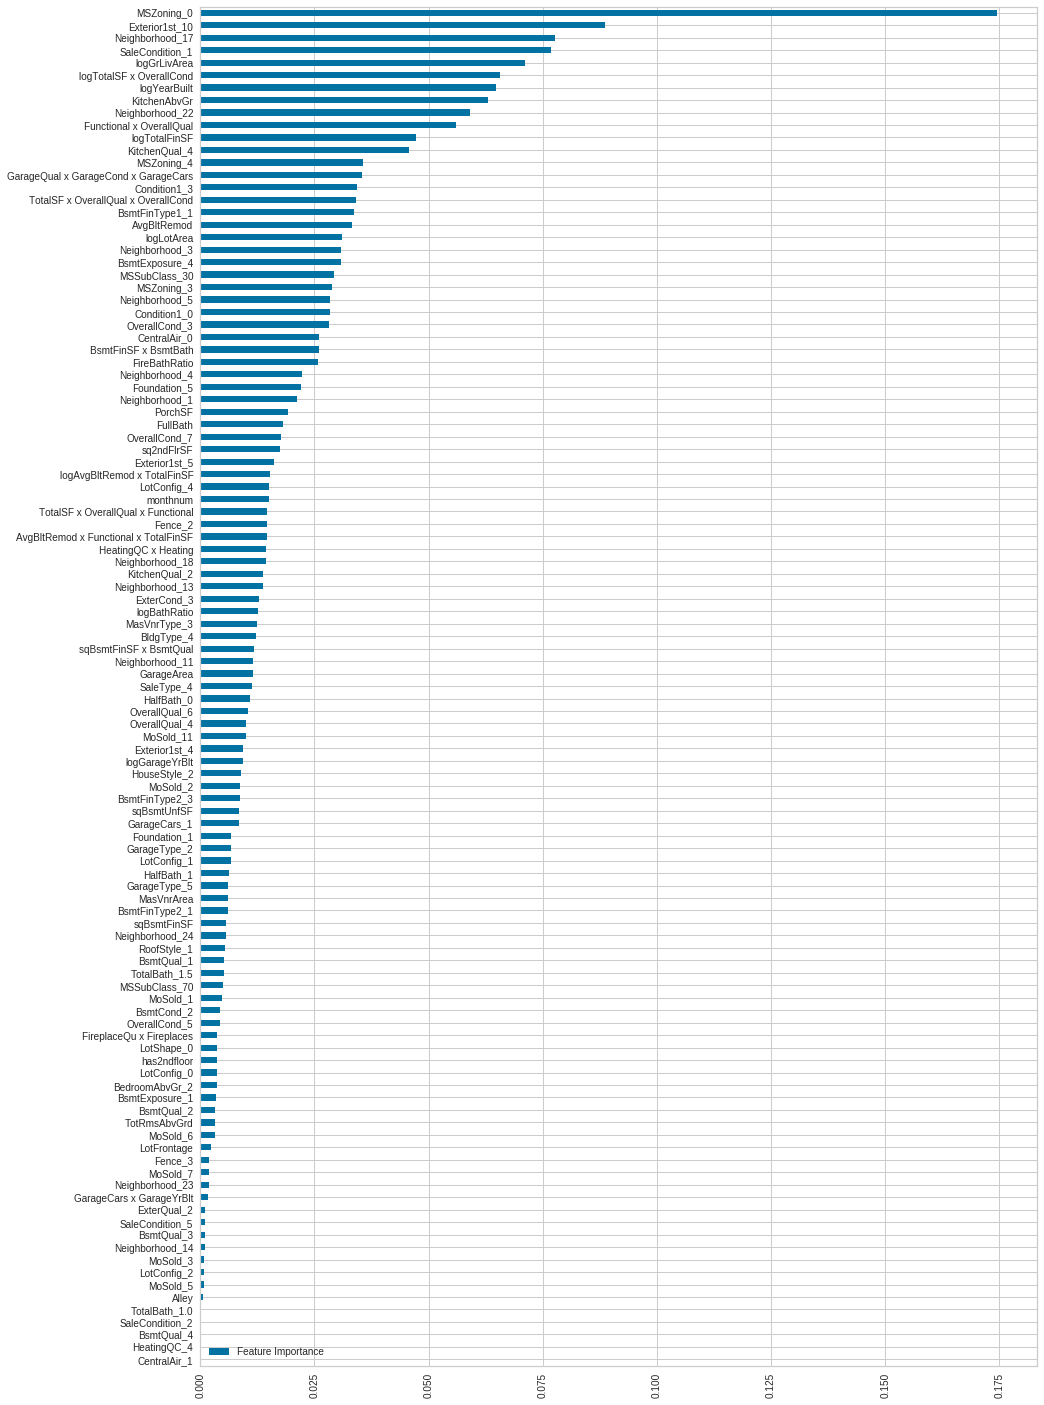

In [64]:
imp_lasso = pd.DataFrame({"Feature Importance" : lasso._final_estimator.coef_}, index=predictors)
imp_lasso["Feature Importance"]=abs(imp_lasso["Feature Importance"])
imp_lasso[imp_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

Train RMSE 16532.08739231188
Train R-squared 0.9516195572457897
Train MAE 10999.808698504952

Test RMSE 20520.482408561074
Test R-squared 0.9358655337244645
Test MAE 13103.773058503048
alpha 25.11886431509581


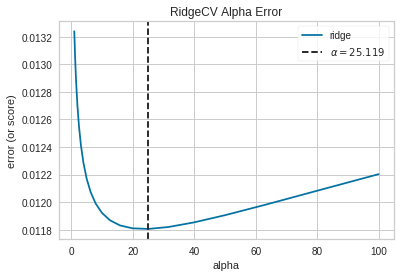

CPU times: user 996 ms, sys: 28 ms, total: 1.02 s
Wall time: 206 ms


In [65]:
%%time
# visualize ridge with yellowbrick
scaler = use_transform()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)

#alphas = np.logspace(-2, 3, 11)
alphas = np.logspace(0, 2, 21)
visualizer = AlphaSelection(RidgeCV(alphas=alphas))
visualizer.fit(X_tr, y_train)

y_pred_train = visualizer.predict(X_tr)
y_pred_test = visualizer.predict(scaler.transform(X_test))
evaluate(y_train, y_pred_train, y_test, y_pred_test)

alpha = visualizer.estimator.alpha_
print('alpha', alpha)
visualizer.poof()

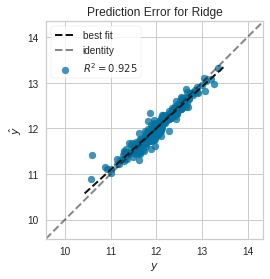

CPU times: user 720 ms, sys: 16 ms, total: 736 ms
Wall time: 123 ms


In [66]:
%%time
visualizer = PredictionError(Ridge(alpha=alpha))
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [67]:
%%time
# tune RidgeCV search space
alphas = np.logspace(0, 2, 21)

ridge = make_pipeline(use_transform(),
                      RidgeCV(cv=kfolds, alphas=alphas))

scores = np.sqrt(-cross_val_score(ridge, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))
print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

ridge.fit(X_train, y_train)

y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('alpha', ridge._final_estimator.alpha_)


CV Score 0.1078 (STD 0.0125)

Train RMSE 16532.08739231353
Train R-squared 0.9516195572457801
Train MAE 10999.808698503335

Test RMSE 20520.482408564818
Test R-squared 0.935865533724441
Test MAE 13103.77305850099
alpha 25.11886431509581
CPU times: user 1min 45s, sys: 1.61 s, total: 1min 47s
Wall time: 18 s


In [68]:
%%time
# Tune ElasticNetCV search space for alphas and l1_ratio
print("ElasticNetCV")

elasticnet = make_pipeline(use_transform(),
                           ElasticNetCV(max_iter=100000, 
                                        #l1_ratio=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
                                        l1_ratio=np.linspace(0.6, 0.8, 21),
                                        alphas=np.logspace(-4, -2, 21),
                                        cv=kfolds))

scores = np.sqrt(-cross_val_score(elasticnet, df[predictors], df[response],
                                  scoring="neg_mean_squared_error",
                                  cv=kfolds))

print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
print()

elasticnet.fit(X_train, y_train)

y_pred_train = elasticnet.predict(X_train)
y_pred_test = elasticnet.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)
print('l1_ratio', elasticnet._final_estimator.l1_ratio_)
print('alpha', elasticnet._final_estimator.alpha_)


ElasticNetCV
CV Score 0.1062 (STD 0.0120)

Train RMSE 17203.123924151376
Train R-squared 0.9476123292499731
Train MAE 11385.493573716929

Test RMSE 20171.578723420862
Test R-squared 0.9380279116399379
Test MAE 12806.141107761603
l1_ratio 0.73
alpha 0.001
CPU times: user 15min 31s, sys: 13.3 s, total: 15min 44s
Wall time: 2min 50s


In [69]:
%%time
# tune KernelRidge
print("KernelRidge")

kralphas = np.logspace(-5,0,11)
kralpha = 0.03162277660168379

# linear, poly
# degree 1,2,3
coef0s = np.linspace(1,10, 19)
coef0=6

krdegrees = [1,2,3]
krdegree = 1

for i in [1]:

    kr = make_pipeline(use_transform(),
                       KernelRidge(alpha=kralpha, kernel='poly', degree=krdegree, coef0=coef0)
                      )
    print(kr)
    scores = np.sqrt(-cross_val_score(kr, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()

    kr.fit(X_train, y_train)

    y_pred_train = kr.predict(X_train)
    y_pred_test = kr.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
    

KernelRidge
Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('kernelridge',
                 KernelRidge(alpha=0.03162277660168379, coef0=6, degree=1,
                             gamma=None, kernel='poly', kernel_params=None))],
         verbose=False)
CV Score 0.1074 (STD 0.0121)

Train RMSE 15908.27219025297
Train R-squared 0.9552018086967982
Train MAE 10619.411383061246

Test RMSE 20209.03298855776
Test R-squared 0.937797560414707
Test MAE 12854.365773729136
CPU times: user 4.81 s, sys: 104 ms, total: 4.92 s
Wall time: 820 ms


In [70]:
%%time
# tune SVR
print("SVR")

Cs = np.logspace(0,2,5)
C = 3.1622776601683795

epsilons = np.logspace(-5,0,11)
epsilon = 0.03162277660168379

svrgammas = np.logspace(-5,0,11)
svrgamma = 0.001

for i in [1]:

    svr = make_pipeline(use_transform(),
                        SVR(kernel='rbf', 
        #                        degree=3, 
                            gamma=svrgamma,
        #                        coef0=0.0, 
        #                        tol=0.001, 
                            C=C, 
                            epsilon=epsilon, 
        #                        shrinking=True, 
        #                        cache_size=200, 
        #                        verbose=False, 
        #                        max_iter=-1))
                           ))
    print(svr)
    
    scores = np.sqrt(-cross_val_score(svr, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()

    svr.fit(X_train, y_train)

    y_pred_train = svr.predict(X_train)
    y_pred_test = svr.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)

    print()


SVR
Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('svr',
                 SVR(C=3.1622776601683795, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.03162277660168379, gamma=0.001, kernel='rbf',
                     max_iter=-1, shrinking=True, tol=0.001, verbose=False))],
         verbose=False)
CV Score 0.1064 (STD 0.0125)

Train RMSE 15069.966342514923
Train R-squared 0.9597987998597693
Train MAE 9384.897021155333

Test RMSE 21203.25094523026
Test R-squared 0.9315266999367844
Test MAE 12910.171116429427

CPU times: user 6.63 s, sys: 32 ms, total: 6.66 s
Wall time: 5.99 s


In [71]:
%%time
# tune Gradient Boost
print("Gradient Boost")
gbestimatorss = np.logspace(2,4,9)
gbestimators = 5623
gbdepth = 2
gblearnrate = 0.01

for i in range(1):
                           
    gb = GradientBoostingRegressor(n_estimators=int(gbestimators), 
                                   learning_rate=gblearnrate,
                                   max_depth=gbdepth, 
                                   max_features='sqrt',
                                   min_samples_leaf=16, 
                                   loss='huber', 
                                   subsample=0.8, 
                                   random_state=42)
    print(gb)
    
    scores = np.sqrt(-cross_val_score(gb, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
    print()

    gb.fit(X_train, y_train)
    
    y_pred_train = gb.predict(X_train)
    y_pred_test = gb.predict(X_test)
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
    print()
    

Gradient Boost
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='huber', max_depth=2,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=16, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5623,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
CV Score 0.1083 (STD 0.0141)

Train RMSE 13540.117132480857
Train R-squared 0.9675466677201102
Train MAE 8205.31951670703

Test RMSE 23418.63764386616
Test R-squared 0.9164705530231663
Test MAE 13738.366249428924

CPU times: user 1min 8s, sys: 76 ms, total: 1min 8s
Wall time: 1min 8s


In [72]:
%%time
# tune XGBoost
print("XGBoost")
# XGboost - sophisticated decision tree model
# tuned sequentially
# no log1p

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 5623

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 3

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.55

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:
 
        xgb = XGBRegressor(
            objective='reg:linear',
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
        display(xgb)
        
        scores = np.sqrt(-cross_val_score(xgb, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
        
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()

xgb.fit(X_train, y_train.values.reshape(-1))
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)


XGBoost


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.15, gamma=0, importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=0, missing=None, n_estimators=5623, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.55)

CV Score 0.1089 (STD 0.0136)

Train RMSE 5566.336900934478
Train R-squared 0.9945152930199166
Train MAE 4019.5061777415353

Test RMSE 24435.786819187935
Test R-squared 0.9090570562787769
Test MAE 13820.781979739006
CPU times: user 11min 8s, sys: 8.71 s, total: 11min 16s
Wall time: 1min 16s


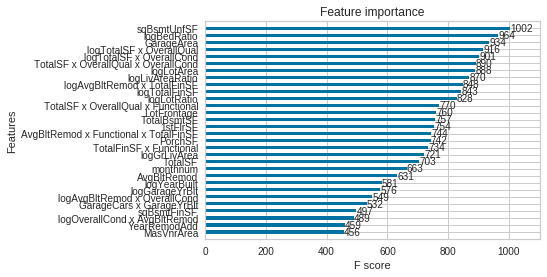

In [73]:
plot_importance(xgb, max_num_features=30, height=0.5)

In [74]:
%%time
# get xgboost interactions, terms that show up in same prediction trees
# alternatives to find interactions:
#   generate many/all interactions (product, ratio, top 30 vs rest) and correlate vs. the residual
#   generate many/all interactions and do lasso to see which ones are retained
interactions = xgb._Booster.predict(xgboost.DMatrix(df[predictors]), pred_interactions=True)
interaction_matrix = np.mean(np.abs(interactions), axis=0)
# last row, col = bias term
interaction_matrix = interaction_matrix[:-1,:-1]
np.fill_diagonal(interaction_matrix, 0)
interaction_matrix.shape


CPU times: user 1h 34min 10s, sys: 13.9 s, total: 1h 34min 24s
Wall time: 9min 47s


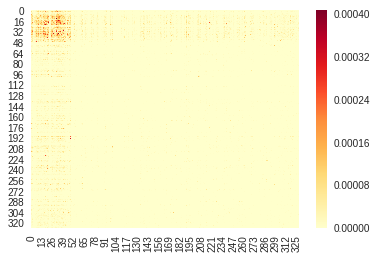

In [75]:
# chart
sns.heatmap(np.abs(interaction_matrix), cmap="YlOrRd", linewidths=0, annot=False, annot_kws={'size': 9}, fmt='.4f');


In [76]:
# print high interaction pairs
# last row, col = bias term
# could also sort, not print out symmetrical pairs
nrows, ncols = interaction_matrix.shape
z = interaction_matrix.copy()[:nrows, :ncols]
z = z.reshape((nrows * ncols))
z.sort()
threshold = z[-100]
print(threshold)
threshold = .0002

for i in range(interaction_matrix.shape[0]-1):
    for j in range(interaction_matrix.shape[1]-1):
        if interaction_matrix[i,j] > threshold:
            print(predictors[i], predictors[j], interaction_matrix[i,j])
            

0.0001897659
YearRemodAdd TotalSF 0.0002104582
YearRemodAdd TotalSF x OverallQual x Functional 0.0002377121
logGarageYrBlt FireplaceQu x Fireplaces 0.00028752658
logLotArea GarageArea 0.0002207927
logLotArea AvgBltRemod 0.00022124432
logLotArea logBedRatio 0.0002004828
logLotArea logTotalSF x OverallCond 0.0002215839
TotalBsmtSF TotalSF x OverallQual x OverallCond 0.00040558114
logGrLivArea logBedRatio 0.00021073528
logGrLivArea TotalSF x OverallQual x OverallCond 0.00021564851
logGrLivArea TotalSF x OverallQual x Functional 0.00020647599
logGrLivArea logTotalSF x OverallQual 0.00034131293
logGrLivArea logTotalSF x OverallCond 0.00025708412
GarageArea logLotArea 0.00022079247
logTotalFinSF TotalSF 0.00021670981
logTotalFinSF sqBsmtFinSF 0.00020682575
logTotalFinSF AvgBltRemod 0.00023198793
logTotalFinSF TotalSF x OverallQual x Functional 0.00020719008
TotalSF YearRemodAdd 0.00021045837
TotalSF logTotalFinSF 0.00021670946
TotalSF AvgBltRemod 0.0003371773
TotalSF TotalSF x OverallQual x 

In [77]:
%%time
# tune LightGBM
print("LightGBM")
#n_estimators_lgbm: number of base learner trees
n_estimators_lgbms=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_lgbm = 5623

#max_depth: max depth per base tree
num_leavess = range(2,12)
num_leaves = 5

#subsample: row subsampling rate (similar to RF)
bagging_fractions = np.linspace(0.5, 0.8, 11)
bagging_fraction = 0.75

#colsample_bytree: feature subsampling rate (similar to RF)
feature_fractions = np.linspace(0.05, 0.3, 26)
feature_fraction = 0.1

#learning_rate: shrinkage factor applied to each base tree update
learning_rates = np.logspace(-3, 0, 7)
learning_rates = [0.01]
learning_rate_lgbm = 0.01

for i in [1]:
    print(num_leaves,
          n_estimators_lgbm,
          bagging_fraction,
          feature_fraction,
         )
    
    lgbm = LGBMRegressor(objective='regression',
                         num_leaves=num_leaves,
                         learning_rate=learning_rate_lgbm,
                         n_estimators=n_estimators_lgbm,
                         max_bin=200,
                         bagging_fraction=bagging_fraction,
                         feature_fraction=feature_fraction,
                         feature_fraction_seed=7,
                         min_data_in_leaf=2,
                         verbose=-1,
                         )
    
    scores = np.sqrt(-cross_val_score(lgbm, df[predictors], df[response],
                                      scoring="neg_mean_squared_error",
                                      cv=kfolds))
    
    print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))

    print()

lgbm.fit(X_train, y_train.values.reshape(-1))
y_pred_train = lgbm.predict(X_train)
y_pred_test = lgbm.predict(X_test)
evaluate(y_train, y_pred_train, y_test, y_pred_test)


LightGBM
5 5623 0.75 0.1
CV Score 0.1087 (STD 0.0127)

Train RMSE 7489.21508005727
Train R-squared 0.9900714218191878
Train MAE 5404.199714904678

Test RMSE 23686.28938077944
Test R-squared 0.914550325218971
Test MAE 13970.335817922594
CPU times: user 8min 4s, sys: 5.76 s, total: 8min 10s
Wall time: 56.3 s


In [78]:
# tune MLPRegressor
print("MLPregressor")

activations = ['relu']
activation = 'relu'

solvers = ['lbfgs']
solver = 'lbfgs'

alphas = np.logspace(0, 2, 3)
alphas = [10]
alpha = 10

learning_rates = ['invscaling']
learning_rate = 'invscaling'

nhiddenlayerss = [1]
nstartlayers = [16, 32, 64, 128,]
layerspecs = product(nhiddenlayerss, nstartlayers)
layerspec = [1, 128]

results_dict = {}

paramlist = product(layerspecs, 
                    activations, 
                    solvers, 
                    alphas, 
                    learning_rates)

mlpmodels = []
for i, (layerspec, activation, solver, alpha, learning_rate) in enumerate(paramlist):
#for i in [1]:
    
    nhiddenlayers, nstartlayer = layerspec
    key = (nhiddenlayers, nstartlayer, alpha)
    mlplayers = []
    for j in range(nhiddenlayers):
        mlplayers.append(nstartlayer)
        nstartlayer = nstartlayer // 4

    print("Iteration %d: %s, %s, %s, alpha = %f, learning rate = %s" % (i,
                            str(mlplayers),
                            activation,
                            solver,
                            alpha,
                            learning_rate,
                           ))
    
    mlp = make_pipeline(use_transform(),
                        MLPRegressor(hidden_layer_sizes=mlplayers,
                                     activation=activation,
                                     solver=solver,
                                     alpha=alpha,
                                     learning_rate=learning_rate,
                                     max_iter=10000))
    
    #print(mlp)
    mlpmodels.append(mlp)
    
    try:
        scores = np.sqrt(-cross_val_score(mlp, df[predictors], df[response],
                                          scoring="neg_mean_squared_error",
                                          cv=kfolds))
        results_dict[key] = np.mean(scores)
        print("CV Score %.04f (STD %.04f)" % (np.mean(scores), np.std(scores)))
        print()
    except:
        pass

mlp.fit(X_train, y_train.values.reshape(-1))
y_pred_train = mlp.predict(X_train)
y_pred_test = mlp.predict(X_test)
try:
    evaluate(y_train, y_pred_train, y_test, y_pred_test)
except:
    pass


MLPregressor
Iteration 0: [16], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1079 (STD 0.0125)

Iteration 1: [32], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1077 (STD 0.0126)

Iteration 2: [64], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1079 (STD 0.0126)

Iteration 3: [128], relu, lbfgs, alpha = 10.000000, learning rate = invscaling
CV Score 0.1078 (STD 0.0126)

Train RMSE 17093.939183531147
Train R-squared 0.9482752068338411
Train MAE 11357.669921098106

Test RMSE 21048.046670567404
Test R-squared 0.9325254575030907
Test MAE 13428.371879981061


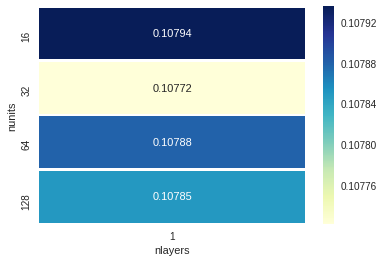

In [79]:
mlp_matrix = pd.DataFrame({
    'nlayers' : [k[0] for k in results_dict.keys()],
    'nunits' : [k[1] for k in results_dict.keys()],
    'alpha' : [np.round(k[2],4) for k in results_dict.keys()],
    'score' : [s for s in results_dict.values()],
})

mlp_pivot = mlp_matrix.pivot_table(index='nunits', 
                                   columns='nlayers',
                                   values='score', 
                                   aggfunc='mean')

sns.heatmap(mlp_pivot, cmap="YlGnBu", linewidths=1.5, annot=True, annot_kws={'size': 11}, fmt='.5f')


### 5. Train and evaluate tuned models on full training set

In [80]:
# drop outliers with big misses before retrain on full training set, so they don't distort test for submission

#outliers = [30, 88, 462, 631, 1322]
# big raw misses 
# outliers = [687, 801, 896, 1320, 631]

outliers = [687, 801, 896, 1320, 1449, 462, 631]
df=df.reset_index(drop=True)
print(df.loc[outliers][response])
print(np.expm1(df.loc[outliers][response]))


687     12.879020
801     13.275829
896     13.323929
1320    11.898195
1449    11.344519
462     11.041064
631     11.320566
Name: SalePrice, dtype: float64
687     392000.0
801     582933.0
896     611657.0
1320    147000.0
1449     84500.0
462      62383.0
631      82500.0
Name: SalePrice, dtype: float64


In [81]:
print(df[predictors].shape)
df.drop(outliers, inplace=True)
# if you don't reset index here, then on assigment of model results some indexes don't line up and you get NAs 
df=df.reset_index(drop=True)
print(df[predictors].shape)
df.tail()


(1456, 328)
(1449, 328)


,Alley,logYearBuilt,YearRemodAdd,BsmtFullBath,FullBath,KitchenAbvGr,TotRmsAbvGrd,logGarageYrBlt,LotFrontage,logLotArea,MasVnrArea,sqBsmtUnfSF,TotalBsmtSF,1stFlrSF,sq2ndFlrSF,logGrLivArea,GarageArea,SalePrice,logTotalFinSF,TotalSF,sqBsmtFinSF,PorchSF,AvgBltRemod,haspool,has2ndfloor,hasfireplace,logLivAreaRatio,logBedRatio,GarageRatio,logBathRatio,logLotRatio,FireBathRatio,TotalSF x OverallQual x OverallCond,TotalSF x OverallQual x Functional,AvgBltRemod x Functional x TotalFinSF,logTotalSF x OverallQual,logTotalSF x OverallCond,TotalFinSF x Functional,Functional x OverallQual,logAvgBltRemod x OverallCond,logAvgBltRemod x TotalFinSF,logOverallCond x AvgBltRemod,sqBsmtFinSF x BsmtQual,BsmtFinSF x BsmtBath,KitchenAbvGr x KitchenQual,GarageCars x GarageYrBlt,GarageQual x GarageCond x GarageCars,HeatingQC x Heating,FireplaceQu x Fireplaces,monthnum,MSSubClass_120,MSSubClass_160,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,Neighborhood_0,Neighborhood_1,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_2,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_4,Condition2_6,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_3,RoofMatl_4,RoofMatl_6,Exterior1st_0,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior2nd_1,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_2,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_4,Heating_5,CentralAir_0,CentralAir_1,GarageType_0,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,GarageType_6,SaleType_0,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_0,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,LotShape_0,LotShape_1,LotShape_2,LandSlope_0,LandSlope_1,LandSlope_2,OverallQual_10,OverallQual_2,OverallQual_3,OverallQual_4,OverallQual_5,OverallQual_6,OverallQual_7,OverallQual_8,OverallQual_9,OverallCond_2,OverallCond_3,OverallCond_4,OverallCond_5,OverallCond_6,OverallCond_7,OverallCond_8,OverallCond_9,ExterQual_1,ExterQual_2,ExterQual_3,ExterQual_4,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,Electrical_0,Electrical_2,Electrical_3,Electrical_4,KitchenQual_1,KitchenQual_2,KitchenQual_3,KitchenQual_4,Functional_0,Functional_1,Functional_2,Functional_3,Functional_4,GarageFinish_0,GarageFinish_1,GarageFinish_2,GarageFinish_3,GarageQual_1,GarageQual_2,GarageQual_3,GarageCond_0,GarageCond_1,GarageCond_2,GarageCond_3,PavedDrive_0,PavedDrive_2,PoolQC_0,Fence_0,Fenc

In [82]:
# store results
full_train_df = pd.DataFrame({'log_y': df[response],
                             'true_y': np.expm1(df[response])
                             })

xval_df = pd.DataFrame({'log_y': df[response],
                       'true_y': np.expm1(df[response])
                       })

cvscores = {}


In [83]:
%%time
# linear models with dummies
models = {
    'lasso'     : lasso,
    'ridge'     : ridge,
    'elasticnet': elasticnet,
    'kr'        : kr,
    'svr'       : svr,
}

for k, m in models.items():
    print(datetime.datetime.now(), k)
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[predictors], df[response])
    full_train_df[k] = m.predict(df[predictors])
    
    print()

2019-06-06 20:10:11.785720 lasso
CV Score 0.1003

2019-06-06 20:10:16.185226 ridge
CV Score 0.1027

2019-06-06 20:10:29.793331 elasticnet
CV Score 0.1005

2019-06-06 20:13:22.708500 kr
CV Score 0.1018

2019-06-06 20:13:23.461546 svr
CV Score 0.1007

CPU times: user 19min, sys: 14.6 s, total: 19min 15s
Wall time: 3min 17s


In [84]:
%%time
# could use simple model specifications w/no dummies - boost, neural net maybe perform slightly better
models = {
    'xgb'       : xgb, 
    'lgbm'      : lgbm,
    'gb'        : gb,
}

for i, m in enumerate(mlpmodels):
    models["mlp%d" % i] = m
    
for k, m in models.items():
    print(datetime.datetime.now(), k)
    # xval predictions
    xval_df[k] = cross_val_predict(m, df[predictors], df[response], cv=kfolds)

    # cross-val score
    cvscores[k] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[k]))
    print("CV Score %.04f" % (cvscores[k]))

    # full train
    m.fit(df[predictors], df[response])
    full_train_df[k] = m.predict(df[predictors])
    
    print()

2019-06-06 20:13:29.713572 xgb
CV Score 0.1043

2019-06-06 20:14:55.983984 lgbm
CV Score 0.1038

2019-06-06 20:16:03.980989 gb
CV Score 0.1036

2019-06-06 20:17:13.141566 mlp0
CV Score 0.1024

2019-06-06 20:17:17.819447 mlp1
CV Score 0.1023

2019-06-06 20:17:24.732951 mlp2
CV Score 0.1023

2019-06-06 20:17:37.204713 mlp3
CV Score 0.1022

CPU times: user 27min 11s, sys: 20.3 s, total: 27min 32s
Wall time: 4min 31s


In [85]:
blends = {
    'boost_blend': ['xgb', 'lgbm'],
    'linear_blend': ['lasso','ridge','elasticnet','kr'],
    'mlp_blend': ['mlp0', 'mlp1', 'mlp2', 'mlp3'],
}

for blend, components in blends.items():
    xval_df[blend] = np.mean(xval_df[components], axis=1)
    full_train_df[blend] = np.mean(full_train_df[components], axis=1)
    cvscores[blend] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df[blend]))
    print("%s CV Score %.04f" % (blend, cvscores[blend]))


boost_blend CV Score 0.1032
linear_blend CV Score 0.1006
mlp_blend CV Score 0.1023


In [86]:
len(predictors)

328

In [87]:
list(zip(predictors, list(lasso._final_estimator.coef_)))

[('Alley', 0.0015952932196474296),
 ('logYearBuilt', -0.04995056356668763),
 ('YearRemodAdd', -0.0),
 ('BsmtFullBath', 0.007554038885201277),
 ('FullBath', 0.0205275462834117),
 ('KitchenAbvGr', -0.05612268493958283),
 ('TotRmsAbvGrd', 0.0),
 ('logGarageYrBlt', -0.0076742184953843065),
 ('LotFrontage', 0.0038880448282472887),
 ('logLotArea', 0.03390071989088715),
 ('MasVnrArea', 0.005723291733364314),
 ('sqBsmtUnfSF', 0.006581383716912729),
 ('TotalBsmtSF', -0.0),
 ('1stFlrSF', 0.0),
 ('sq2ndFlrSF', 0.01907956809468923),
 ('logGrLivArea', 0.05836664523059598),
 ('GarageArea', 0.00922378900223833),
 ('logTotalFinSF', 0.07558660787496002),
 ('TotalSF', 0.0),
 ('sqBsmtFinSF', -0.012557005623926637),
 ('PorchSF', 0.02237360956734771),
 ('AvgBltRemod', -0.037324470280547396),
 ('haspool', 0.0),
 ('has2ndfloor', -0.018635561748363602),
 ('hasfireplace', 0.0),
 ('logLivAreaRatio', 0.0),
 ('logBedRatio', -0.0),
 ('GarageRatio', 0.0),
 ('logBathRatio', 0.010097191399879416),
 ('logLotRatio', 0.

In [88]:
list(zip(predictors, list(xgb.feature_importances_)))

[('Alley', 0.0013222338),
 ('logYearBuilt', 0.0077907336),
 ('YearRemodAdd', 0.0037614172),
 ('BsmtFullBath', 0.0009816061),
 ('FullBath', 0.00913103),
 ('KitchenAbvGr', 0.005061697),
 ('TotRmsAbvGrd', 0.00097100285),
 ('logGarageYrBlt', 0.0024868522),
 ('LotFrontage', 0.0016378108),
 ('logLotArea', 0.0038521742),
 ('MasVnrArea', 0.0008880409),
 ('sqBsmtUnfSF', 0.0015568257),
 ('TotalBsmtSF', 0.0017217053),
 ('1stFlrSF', 0.0021494317),
 ('sq2ndFlrSF', 0.0013823333),
 ('logGrLivArea', 0.006412366),
 ('GarageArea', 0.004343296),
 ('logTotalFinSF', 0.011236645),
 ('TotalSF', 0.018088214),
 ('sqBsmtFinSF', 0.001205748),
 ('PorchSF', 0.0027644061),
 ('AvgBltRemod', 0.010316952),
 ('haspool', 0.0011450737),
 ('has2ndfloor', 0.0010736901),
 ('hasfireplace', 0.020667827),
 ('logLivAreaRatio', 0.0020123653),
 ('logBedRatio', 0.0013689908),
 ('GarageRatio', 0.0025395819),
 ('logBathRatio', 0.0031230066),
 ('logLotRatio', 0.0017568583),
 ('FireBathRatio', 0.0032491866),
 ('TotalSF x OverallQual x

### 6. Stack and Blend

In [89]:
%%time
#concatenate raw predictors, blends, and stack with xgb
# something off about this , CV is worse than individual blends
# I think last step maybe should be xval_predict using full train data

df_stack_xval = pd.DataFrame(df[predictors], columns=predictors)
df_stack_xval = pd.concat((df_stack_xval, xval_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
df_stack_xval = use_transform().fit_transform(df_stack_xval)

#n_estimators_xgb: number of base learner trees
n_estimators_xgbs=[100, 178, 316, 562, 1000, 1778, 3162, 5623, 10000]
n_estimators_xgb = 1000

#max_depth: max depth per base tree
max_depths = range(2,12)
max_depth = 2

#subsample: row subsampling rate (similar to RF)
subsamples = np.linspace(0.4, 0.8, 9)
subsample = 0.4

#colsample_bytree: feature subsampling rate (similar to RF)
colsample_bytrees = np.linspace(0.1, 0.8, 15)
colsample_bytree = 0.15

reg_alphas = np.logspace(-7, 0, 15)
reg_alpha = 1e-05

gammas = [0, 1, 5]
gammas = [0]
gamma = 0

#learning_rate_xgb: shrinkage factor applied to each base tree update
learning_rate_xgbs = np.logspace(-2, 0, 5)
learning_rate_xgbs = [0.01]
learning_rate_xgb = 0.01

for i in [1]:

    stack_xgb = XGBRegressor(
            max_depth=max_depth,
            n_estimators=n_estimators_xgb,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            learning_rate=learning_rate_xgb,
            min_child_weight=0,
            reg_alpha=reg_alpha,
            n_jobs=-1)
    
    display(stack_xgb)

    xval_df['stack_xgb'] = cross_val_predict(stack_xgb,
                                             df_stack_xval, 
                                             xval_df['log_y'], 
                                             cv=kfolds)
    cvscores['stack_xgb'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack_xgb']))
    print("%s CV score %.04f" % ('stack_xgb', cvscores['stack_xgb']))
    
    stack_xgb.fit(df_stack_xval, 
                  xval_df['log_y'])
    
    df_stack_full = pd.DataFrame(df[predictors], columns=predictors)
    df_stack_full = pd.concat((df_stack_full, full_train_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
    df_stack_full = use_transform().fit_transform(df_stack_full)
    
    full_train_df['stack_xgb'] = stack_xgb.predict(df_stack_xval)
    print("%s full train score %.04f" % ('stack_xgb', np.sqrt(mean_squared_error(full_train_df['log_y'], full_train_df['stack_xgb']))))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.15, gamma=0, importance_type='gain',
             learning_rate=0.01, max_delta_step=0, max_depth=2,
             min_child_weight=0, missing=None, n_estimators=1000, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.4)

stack_xgb CV score 0.1050
stack_xgb full train score 0.0871
CPU times: user 1min 34s, sys: 1.5 s, total: 1min 36s
Wall time: 11.1 s


In [90]:
%%time
# this stack is slow but offers marginal improvement over stacking pre-calculated blends
# with use_features_in_secondary we probably need to scale 

#boost_blend =  VotingRegressor(estimators=[('xgb', xgb), ('lgbm', lgbm)])
#boost_blend.fit(df[predictors], df[response])

#linear_blend = VotingRegressor(estimators=[('lasso', lasso), 
#                                           ('ridge', ridge), 
#                                           ('elasticnet', elasticnet), 
#                                           ('kr', kr)])
#linear_blend.fit(df[predictors], df[response])

#mlp_blend =    VotingRegressor(estimators=[('mlp%d' % i, mlpmodels[i]) for i in range(len(mlpmodels))])
#mlp_blend.fit(df[predictors], df[response])

stack = make_pipeline(use_transform(),
                      StackingCVRegressor(regressors=[xgb, lgbm, 
                                                      lasso, ridge, elasticnet, kr,
                                                      svr, gb
                                                     ] + mlpmodels,
                                          meta_regressor=stack_xgb,
                                          cv=kfolds,
                                          use_features_in_secondary=True))

print(datetime.datetime.now(), "stack xval")
xval_df['stack'] = cross_val_predict(stack, df[predictors].values, df[response].values, cv=kfolds)
print(datetime.datetime.now(), "xval finished")

# compute crossval score
cvscores['stack'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stack']))
print(datetime.datetime.now(), "stack crossval score %.6f" % cvscores['stack'])

print(datetime.datetime.now(), "full train")
stack.fit(df[predictors].values, df[response].values)
full_train_df['stack'] = stack.predict(df[predictors].values)
print(datetime.datetime.now(), "full train finished")


2019-06-06 20:18:12.727233 stack xval
2019-06-06 21:34:47.110044 xval finished
2019-06-06 21:34:47.111043 stack crossval score 0.102323
2019-06-06 21:34:47.111251 full train
2019-06-06 21:42:24.474344 full train finished
CPU times: user 8h 1min 8s, sys: 6min 14s, total: 8h 7min 22s
Wall time: 1h 24min 11s


In [91]:
%%time
# stack again using a weighted average.
# 1st level stack does xval_predict using base models and features, meta prediction using base features+predictions
# 2nd level fit lasso model to the base models + stack
# get a weighted avg of all models, no intercept, positive coefs
# on further review, fit_intercept=False screws it up, puts all weight on 1st model, seems like a bug 

# since individual regressors are pipelines that do scaling
# and the metaregressor doesn't use features
# shouldn't need to transform

# note - this should do the same,
# will re-run all models instead of using xval_df (slower and less explicit)
# blendcv = StackingCVRegressor(regressors=blendpredictors,
#                               meta_regressor=blendlasso,
#                               cv=kfolds,
#                               use_features_in_secondary=False)
# blendcv.fit(df[predictors].values, df[response].values)

print(datetime.datetime.now())

# xgb and lgbm correlation > .998
# xval_df['boostblend'] = xval_df[['xgb', 'lgbm']].mean(axis=1)
# full_train_df['boostblend'] = full_train_df[['xgb', 'lgbm']].mean(axis=1)

# linear models correlation > .998
# xval_df['linearblend'] = xval_df[['elasticnet', 'ridge', 'lasso','kr']].mean(axis=1)
# full_train_df['linearblend'] = full_train_df[['elasticnet', 'ridge', 'lasso','kr']].mean(axis=1)

# 3 ML models
# xval_df['mlpblend'] = xval_df[['mlp0', 'mlp1', 'mlp2']].mean(axis=1)
# full_train_df['mlpblend'] = full_train_df[['mlp0', 'mlp1', 'mlp2']].mean(axis=1)

blendlasso = LassoCV(alphas=np.logspace(-6, -4, 5),
                     max_iter=100000,
                     cv=kfolds,
                     fit_intercept=True,
                     positive=True)
                           
blendpredictors = ['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]
blendlasso.fit(xval_df[blendpredictors],
               xval_df['log_y'])

xval_df['stackblend']=blendlasso.predict(xval_df[blendpredictors])
cvscores['stackblend'] = np.sqrt(mean_squared_error(xval_df['log_y'], xval_df['stackblend']))
print("stackblend crossval score %.6f" % cvscores['stackblend'])

full_train_df['stackblend']= blendlasso.predict(full_train_df[blendpredictors])
print("stackblend full train score %.6f" % np.sqrt(mean_squared_error(full_train_df['log_y'], 
                                                                      full_train_df['stackblend'])))
print('coefs', dict(zip(blendpredictors,
                        list(blendlasso.coef_))))
print('coefs adjusted to sum to 1', blendlasso.coef_/np.sum(blendlasso.coef_))
print('intercept', blendlasso.intercept_)
print('sum', np.sum(blendlasso.coef_))
print('alpha', blendlasso.alpha_ )


2019-06-06 21:42:24.481597
stackblend crossval score 0.098517
stackblend full train score 0.071068
coefs {'stack': 0.03197673649378231, 'stack_xgb': 0.0, 'boost_blend': 0.21388319807308503, 'gb': 0.0976784532842357, 'mlp_blend': 0.0, 'svr': 0.41106183133266927, 'linear_blend': 0.2612325728598379}
coefs adjusted to sum to 1 [0.03147835 0.         0.21054961 0.09615603 0.         0.40465501
 0.257161  ]
intercept -0.19351327087394665
sum 1.0158327920436103
alpha 0.0001
CPU times: user 236 ms, sys: 4 ms, total: 240 ms
Wall time: 27 ms


In [92]:
xval_df.head()

,log_y,true_y,lasso,ridge,elasticnet,kr,svr,xgb,lgbm,gb,mlp0,mlp1,mlp2,mlp3,boost_blend,linear_blend,mlp_blend,stack_xgb,stack,stackblend
0,12.247699,208500.0,12.243428,12.236177,12.243458,12.243092,12.265909,12.214085,12.225717,12.231293,12.234959,12.235537,12.233724,12.235592,12.219901,12.241539,12.234740,12.231736,12.238537,12.246136
1,12.109016,181500.0,12.144355,12.143192,12.144228,12.146378,12.117893,12.101287,12.109308,12.085005,12.139731,12.140152,12.140056,12.141171,12.105298,12.144538,12.139980,12.105655,12.114991,12.117201
2,12.317171,223500.0,12.278506,12.264511,12.278655,12.259045,12.287187,12.279025,12.287466,12.271319,12.271003,12.267799,12.269561,12.270728,12.283245,12.270179,12.269454,12.256845,12.260890,12.280538
3,11.849405,140000.0,12.065984,12.032763,12.061604,12.032762,12.053243,12.097291,12.097277,12.081889,12.037221,12.038227,12.040834,12.037356,12.097284,12.048278,12.038761,12.085613,12.067629,12.061947
4,12.429220,250000.0,12.566821,12.574460,12.566802,12.575127,12.560349,12.568513,12.561474,12.570041,12.574264,12.573928,12.571552,12.573007,12.564993,12.570802,12.573248,12.578524,12.569914,12.570678


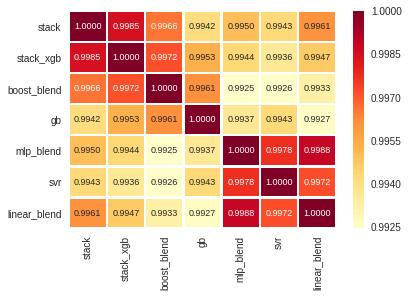

In [93]:
xval_corr = xval_df[blendpredictors].corr()
sns.heatmap(xval_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


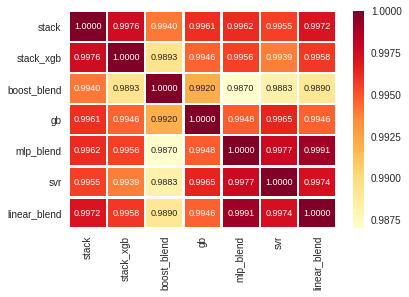

In [94]:
full_train_corr = full_train_df[['stack', 'stack_xgb', 'boost_blend', 'gb', 'mlp_blend', 'svr', 'linear_blend', ]].corr()
sns.heatmap(full_train_corr, cmap="YlOrRd", linewidths=1.5, annot=True, annot_kws={'size': 9}, fmt='.4f');


In [95]:
## review final CV scores

for col in xval_df.columns:
    if col in ['true_y', 'log_y', 'true_pred', 'error_stackblend']:
        continue
        
    print(col)
    evaluate2(xval_df[col], xval_df['log_y'])
    print('CV:', cvscores.get(col))
    print()


lasso
Train RMSE (log) 0.10031927356919483
Train RMSE 17917.841633522872
Train R-squared 0.938694974969582
Train MAE 12064.475392216644
CV: 0.10031927356919483

ridge
Train RMSE (log) 0.10269713444127677
Train RMSE 18077.669303716655
Train R-squared 0.9381636906029722
Train MAE 12271.040022676869
CV: 0.10269713444127677

elasticnet
Train RMSE (log) 0.10052880072279843
Train RMSE 17917.99568967126
Train R-squared 0.9387213530515789
Train MAE 12071.407722718654
CV: 0.10052880072279843

kr
Train RMSE (log) 0.10179171410766567
Train RMSE 17993.063734902207
Train R-squared 0.939187444485646
Train MAE 12183.950930840747
CV: 0.10179171410766567

svr
Train RMSE (log) 0.10065677821924765
Train RMSE 17933.75756950332
Train R-squared 0.9372404727141567
Train MAE 11792.37686038388
CV: 0.10065677821924765

xgb
Train RMSE (log) 0.1043457100701124
Train RMSE 19699.00237271966
Train R-squared 0.923560315973069
Train MAE 12531.082810343345
CV: 0.1043457100701124

lgbm
Train RMSE (log) 0.103825286879546

In [96]:
full_train_df['error_log'] = full_train_df['stackblend'] - full_train_df['log_y']
full_train_df['true_y'] = np.expm1(full_train_df['log_y'])
full_train_df['true_pred'] = np.expm1(full_train_df['stackblend'])
full_train_df['error_stackblend'] = full_train_df['true_pred'] - full_train_df['true_y']
full_train_df.describe()


,log_y,true_y,lasso,ridge,elasticnet,kr,svr,xgb,lgbm,gb,mlp0,mlp1,mlp2,mlp3,boost_blend,linear_blend,mlp_blend,stack_xgb,stack,stackblend,error_log,true_pred,error_stackblend
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,12.021308,179666.820566,12.021308,12.021308,12.021308,12.021264,12.027083,12.021504,12.021308,12.025006,12.021308,12.021276,12.021303,12.021275,12.021399,12.021297,12.021296,12.020520,12.020770,12.020860,-0.000448,179134.132608,-532.687958
std,0.391841,74938.007771,0.379521,0.379689,0.379458,0.380437,0.372942,0.386574,0.385075,0.375706,0.377215,0.377415,0.377378,0.377377,0.385739,0.379659,0.377333,0.377780,0.378984,0.382863,0.071091,73803.975482,12273.095021
min,10.460271,34900.000000,10.650485,10.627132,10.653332,10.626553,10.712004,10.484192,10.472972,10.884461,10.642698,10.641602,10.637434,10.637219,10.478582,10.640378,10.640578,10.637451,10.749894,10.669347,-0.332783,43015.839235,-84565.984387
25%,11.775297,130000.000000,11.765718,11.771273,11.765566,11.770294,11.779303,11.780041,11.778135,11.779627,11.767558,11.767353,11.766089,11.767103,11.779771,11.769221,11.767216,11.771014,11.781690,11.770667,-0.038732,129399.397478,-6063.169300
50%,12.001512,163000.000000,12.005324,11.997358,12.005072,11.997758,12.001991,11.997484,11.998701,12.001655,11.998945,11.999322,11.997951,12.000050,11.998151,12.000412,11.999592,11.997919,12.002404,11.998233,-0.002985,162466.409335,-459.660187
75%,12.271397,213500.000000,12.266740,12.269006,12.267026,12.269067,12.265397,12.263253,12.257319,12.259794,12.264460,12.265698,12.264390,12.264661,12.259138,12.269476,12.265176,12.262484,12.253142,12.266829,0.030794,212527.032613,5201.624592
max,13.345509,625000.000000,13.358744,13.383304,13.358088,13.382325,13.314182,13.338279,13.327134,13.298663,13.377381,13.377625,13.378306,13.377067,13.332706,13.370615,13.377770,13.137866,13.149043,13.343377,0.571057,623669.406272,69797.776526


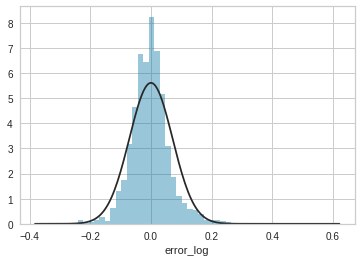

In [97]:
# plot save residuals to analyze vs. columns, interactions
residual = full_train_df[['log_y','true_y', 'true_pred', 'stackblend', 'error_stackblend', 'error_log']]
residual.reset_index(inplace=True)
residual['index'] += 1
residual.to_csv('residual_temp.csv', index=False)

sns.distplot(residual['error_log'], kde=False, fit=stats.norm)


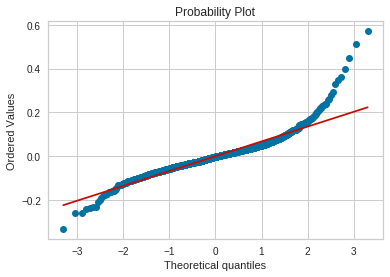

In [98]:
res = stats.probplot(residual['error_log'], plot=plt);

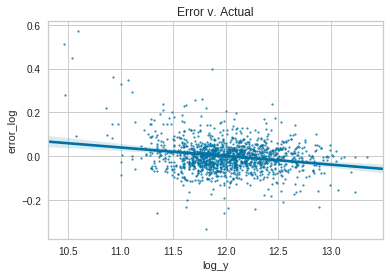

In [99]:
sns.regplot(x="log_y", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Actual');


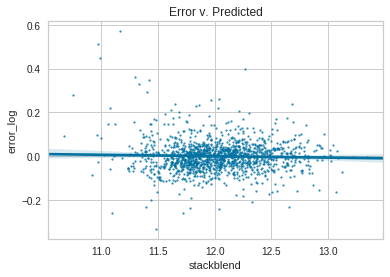

In [100]:
sns.regplot(x="stackblend", y="error_log", data=residual, scatter_kws={"s": 5}).set_title('Error v. Predicted');

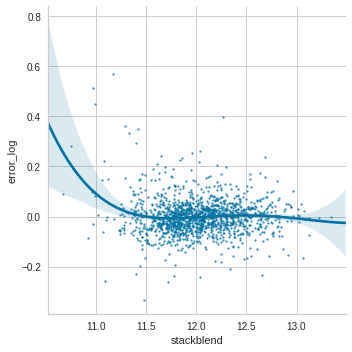

In [101]:
sns.lmplot(x="stackblend", y="error_log", data=residual,
           order=4, scatter_kws={"s": 5});

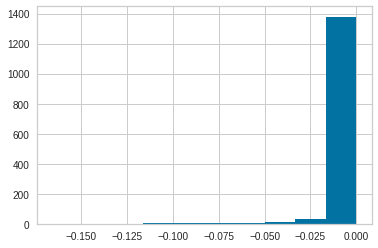

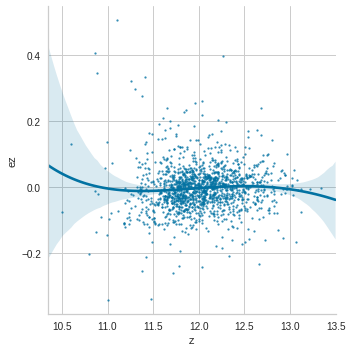

In [102]:
# maybe worth making a kludgy adjustment 
# there might be a more systematic way of forcing toward a prior distribution
full_train_df['bias_adjustment'] = (full_train_df['stackblend'] - 11.5) * 0.2
full_train_df['bias_adjustment'] = full_train_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
full_train_df['bias_adjustment'].hist()
residual['z'] = full_train_df['stackblend'] + full_train_df['bias_adjustment']
residual['ez'] = residual['z'] - residual['log_y']

sns.lmplot(x="z", y="ez", data=residual,
           order=4, scatter_kws={"s": 5});

In [103]:
full_train_df.sort_values('error_stackblend')[['true_y','true_pred','error_stackblend', 'error_log']]
full_train_df.sort_values('error_log')[['true_y','true_pred','error_stackblend', 'error_log']]


,true_y,true_pred,error_stackblend,error_log
963,135000.0,96784.684172,-38215.315828,-0.332783
678,159434.0,122841.083298,-36592.916702,-0.260737
88,85000.0,65628.206450,-19371.793550,-0.258642
328,214500.0,168495.548032,-46004.451968,-0.241399
142,166000.0,130995.616320,-35004.383680,-0.236822
769,395000.0,313232.604445,-81767.395555,-0.231939
1115,112000.0,88874.192176,-23125.807824,-0.231275
13,279500.0,226868.481984,-52631.518016,-0.208631
1204,113000.0,92589.994694,-20410.005306,-0.199205
487,160000.0,131943.219733,-28056.780267,-0.192801


### 7. Run on test set, export CSV for submission

In [108]:
# raw models

submit_df = pd.DataFrame({'xgb'       : xgb.predict(df_test[predictors]), 
                          'lgbm'      : lgbm.predict(df_test[predictors]),
                          'gb'        : gb.predict(df_test[predictors]),
                          'svr'       : svr.predict(df_test[predictors]),
                          'lasso'     : lasso.predict(df_test[predictors]),
                          'ridge'     : ridge.predict(df_test[predictors]),
                          'elasticnet': elasticnet.predict(df_test[predictors]),
                          'kr'        : kr.predict(df_test[predictors]),
                          'stack'     : stack.predict(df_test[predictors])
                         })
for i, m in enumerate(mlpmodels):
    submit_df["mlp%d" % i] = m.predict(df_test[predictors])

#blends

for blend, components in blends.items():
    submit_df[blend] = np.mean(submit_df[components], axis=1)

# fix ids to line up with test
submit_df.reset_index(inplace=True)
submit_df.rename(columns={'index': 'Id'}, inplace=True)
submit_df['Id']+=1461
submit_df.set_index('Id', inplace=True)
                    
# create stack dataset

submit_stack = pd.DataFrame(df_test[predictors],
                            columns=predictors)
submit_stack = pd.concat((submit_stack, submit_df[['boost_blend', 'linear_blend', 'mlp_blend', 'gb', 'svr',]]), axis=1)
submit_stack = use_transform().fit_transform(submit_stack)
submit_df['stack_xgb'] = stack_xgb.predict(submit_stack)

# blend prediction
submit_df['stackblend']=blendlasso.predict(submit_df[blendpredictors])

# force weights to sum to 1, no intercept
submit_df['stackblend2'] = \
     0.03147835 * submit_df['stack'] + \
     0.0        * submit_df['stack_xgb'] + \
     0.21054961  * submit_df['boost_blend'] + \
     0.09615603 * submit_df['gb']  + \
     0.0        * submit_df['mlp_blend'] + \
     0.40465501 * submit_df['svr'] + \
     0.257161 * submit_df['linear_blend']

# alternate rounded weights , floor at 0.05, cap at 0.25
# the stack and a linear model are usually in the top tier, svr and gb are often up there, want to include all
submit_df['stackblend3'] = \
     0.20       * submit_df['stack'] + \
     0.20       * submit_df['boost_blend'] + \
     0.10       * submit_df['gb'] + \
     0.05       * submit_df['mlp_blend'] +\
     0.25       * submit_df['svr'] + \
     0.20       * submit_df['linear_blend'] 

submit_df.head()


,xgb,lgbm,gb,svr,lasso,ridge,elasticnet,kr,stack,mlp0,mlp1,mlp2,mlp3,boost_blend,linear_blend,mlp_blend,stack_xgb,stackblend,stackblend2,stackblend3
Id,,,,,,,,,,,,,,,,,,,,
1461,11.775453,11.751874,11.742634,11.674640,11.669894,11.649599,11.669635,11.656053,11.694433,11.640445,11.642656,11.640401,11.641730,11.763663,11.661295,11.641167,11.743559,11.688798,11.697113,11.698860
1462,11.988841,11.991082,11.978277,12.001738,11.972478,11.981079,11.972395,11.978738,11.981009,11.983709,11.985104,11.984710,11.987496,11.989961,11.976172,11.984508,12.012574,11.986094,11.989776,11.986916
1463,12.141250,12.152195,12.144328,12.154834,12.124791,12.121582,12.124806,12.122519,12.121571,12.120857,12.122042,12.119788,12.122564,12.146723,12.123424,12.120896,12.145481,12.141736,12.142991,12.137530
1464,12.215293,12.200916,12.189362,12.202396,12.193876,12.177413,12.193877,12.178929,12.171279,12.178439,12.178996,12.177775,12.180246,12.208104,12.186024,12.178403,12.178358,12.196757,12.197155,12.191537
1465,12.144639,12.150504,12.159223,12.088377,12.127325,12.118702,12.126996,12.123161,12.126146,12.103083,12.103910,12.105581,12.103071,12.147571,12.124046,12.104191,12.181129,12.116363,12.118014,12.122779


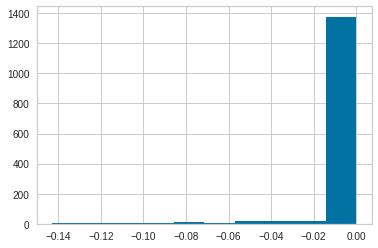

In [109]:
submit_df['bias_adjustment'] = (submit_df['stackblend'] - 11.5) * 0.2
submit_df['bias_adjustment'] = submit_df['bias_adjustment'].apply(lambda x: x if x < 0 else 0)
submit_df['stackblend_adjust'] = submit_df['stackblend'] + submit_df['bias_adjustment']
submit_df['stackblend3_adjust'] = submit_df['stackblend3'] + submit_df['bias_adjustment']
submit_df['bias_adjustment'].hist()

In [110]:
submit_df =np.expm1(submit_df)
submit_df.describe()


,xgb,lgbm,gb,svr,lasso,ridge,elasticnet,kr,stack,mlp0,mlp1,mlp2,mlp3,boost_blend,linear_blend,mlp_blend,stack_xgb,stackblend,stackblend2,stackblend3,bias_adjustment,stackblend_adjust,stackblend3_adjust
count,1459.000000,1459.000000,1459.000000,1459.000000,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1459.000000,1.459000e+03,1.459000e+03,1.459000e+03,1.459000e+03,1459.000000,1.459000e+03,1.459000e+03,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,178510.633427,178506.023812,179128.309892,179260.173354,1.799491e+05,1.800484e+05,1.799463e+05,1.801077e+05,178229.776683,1.799040e+05,1.799075e+05,1.799067e+05,1.799394e+05,178495.030156,1.800029e+05,1.799059e+05,183123.638660,178915.651473,179036.012520,178878.185911,-0.003125,178693.486774,178655.075692
std,77313.455830,77695.102371,76936.370533,76629.244511,9.100338e+04,9.032857e+04,9.098393e+04,9.008566e+04,76221.330855,9.218224e+04,9.196070e+04,9.188034e+04,9.247427e+04,77459.600887,9.055673e+04,9.200672e+04,76506.006189,78787.485659,77449.227684,77490.469251,0.014027,79089.930715,77797.913552
min,41853.452759,39098.473323,56273.354130,52554.733827,4.256472e+04,4.677843e+04,4.276130e+04,4.489004e+04,49842.279235,5.083180e+04,5.055232e+04,5.068018e+04,5.056424e+04,40456.358671,4.421545e+04,5.072027e+04,47588.781577,48284.085077,49378.063747,49193.851294,-0.133267,41849.272751,42637.797080
25%,128273.173002,129272.515081,129042.067244,128145.153313,1.267064e+05,1.264421e+05,1.266751e+05,1.266996e+05,128198.632684,1.263496e+05,1.263442e+05,1.263856e+05,1.263345e+05,128698.331563,1.264421e+05,1.264449e+05,131977.438126,126454.754056,127393.751782,127494.119519,0.000000,126454.754056,127494.119519
50%,157130.155447,157517.595781,158187.293303,157949.230138,1.581786e+05,1.584694e+05,1.581595e+05,1.583963e+05,157023.497076,1.585128e+05,1.586168e+05,1.585160e+05,1.584632e+05,157420.820363,1.582347e+05,1.585227e+05,161897.557103,157339.844273,157969.232701,157861.042823,0.000000,157339.844273,157861.042823
75%,211240.510115,209116.184666,209136.198946,208994.693862,2.104279e+05,2.109024e+05,2.104617e+05,2.107646e+05,209179.894379,2.096242e+05,2.100948e+05,2.096146e+05,2.098729e+05,211423.651675,2.106329e+05,2.097016e+05,217195.378251,210447.979493,210334.225360,209305.169512,0.000000,210447.979493,209305.169512
max,617715.601148,669809.763479,639241.049294,535562.139841,1.971193e+06,1.882076e+06,1.970792e+06,1.844650e+06,494017.712159,2.066444e+06,2.050317e+06,2.042696e+06,2.083614e+06,643235.525882,1.916374e+06,2.053128e+06,487918.230076,571272.572160,562145.744323,622259.448428,0.000000,571272.572160,622259.448428


In [111]:
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['boost_blend']}).to_csv('boost_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['linear_blend']}).to_csv('linear_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['mlp_blend']}).to_csv('mlp_blend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['svr']}).to_csv('svr.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['gb']}).to_csv('gb.csv', index=False)

pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend']}).to_csv('stackblend.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack']}).to_csv('stack.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stack_xgb']}).to_csv('stack_xgb.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend2']}).to_csv('stackblend2.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3']}).to_csv('stackblend3.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend_adjust']}).to_csv('stackblend_adjust.csv', index=False)
pd.DataFrame({'Id': range(1461, 2920), 'SalePrice': submit_df['stackblend3_adjust']}).to_csv('stackblend3_adjust.csv', index=False)

print(datetime.datetime.now())


2019-06-06 21:46:34.602764


 ### If you got this far 
 - At time of writing 05/2019 there are 2 Kaggle contests using this data set
     - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard
     - https://www.kaggle.com/c/home-data-for-ml-course/leaderboard
 - 1st contest is tougher leaderboard, this solution is about .115 log error, #250 / 4500, 
 - Maybe top 5% after accounting for blenders and cheaters LOL
     - looking at people who posted top kernels, some of them blend with other people's results
     - and data is publicly available so it's possible to look up solutions for the test set
 - 2nd contest (InClass) is softer leaderboard, this solution came in about 12500 raw error, rank 30/5000, top 2%
 - Observing that other people blended, I blended output from this with 3 other top kernels:
    - https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force
    - https://www.kaggle.com/couyang/hybrid-svm-benchmark-approach-0-11180-lb-top-2
    - https://www.kaggle.com/zavodrobotov/lasso-model-for-regression-problem
 - Blend achieved #156 and #3 on 2 leaderboards 0.110, 12100
 - Seems pointless to blend but was curious how high I could go
 - Could maybe improve raw model a little further
     - A very careful visual or systematic examination of which predictors should be dummified, transformed
     - Systematic elimination of non-helpful predictors
     - Add additional models, for averaging, stacking
 - Pretty curious how top results were achieved, quite a few in .1106 range, brute force, more clever features, or just blending top kernels?
 